In [1]:
!pip install choix

In [2]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import ast
from torch.utils.data import DataLoader, TensorDataset
from torch.amp import GradScaler, autocast
import choix
from collections import defaultdict
from scipy.stats import kendalltau, spearmanr, rankdata
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, ndcg_score
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm

In [3]:
generator = np.random.default_rng(42)

In [4]:
expert_df = pd.read_csv('/kaggle/input/dataset-final/expert.csv')
amateur_df = pd.read_csv('/kaggle/input/dataset-final/amateur.csv')
spammer_df = pd.read_csv('/kaggle/input/dataset-final/spammer.csv')
malicious_df = pd.read_csv('/kaggle/input/dataset-final/malicious.csv')

In [5]:
n_items = 60
n_initial_samples = 100
n_iterations = 100
n_samples_per_iter = 5

In [6]:
for df in (expert_df, amateur_df, spammer_df, malicious_df):
    df['subset'] = df['subset'].apply(ast.literal_eval)
    df['true rank'] = df['true rank'].apply(ast.literal_eval)
    df['noisy rank'] = df['noisy rank'].apply(ast.literal_eval)

In [7]:
def kendall_tau_score(y_true, y_pred):
    tau, _ = kendalltau(y_true, y_pred)
    return tau

def pl_predict(data):
    return choix.lsr_rankings(n_items=60, data=data)

In [8]:
def ranking_to_map(ranking):
    return {item: rank for rank, item in enumerate(ranking)}

In [9]:
def aligned_rank_vectors(true_ranking, predicted_ranking):
    true_map = ranking_to_map(true_ranking)
    pred_map = ranking_to_map(predicted_ranking)
    all_items = sorted(set(true_ranking) | set(predicted_ranking))
    true_ranks = [true_map[item] for item in all_items]
    pred_ranks = [pred_map[item] for item in all_items]
    return true_ranks, pred_ranks

In [10]:
true_ranking = [35, 21, 22, 58, 37, 43, 42, 41, 24, 26, 3, 30, 31, 18, 12, 6, 49, 0, 38, 27, 11, 53, 57, 14, 32, 23, 10, 8, 25, 39, 47, 54, 59, 44, 2, 52, 46, 13, 20, 45, 28, 1, 33, 40, 5, 51, 15, 50, 9, 55, 56, 7, 19, 29, 36, 48, 34, 17, 16, 4]

## BASELINE MODEL

In [11]:
expert_pl = choix.lsr_rankings(n_items=60, data = expert_df['noisy rank'])
choix.probabilities(range(60), expert_pl)
predicted_ranking_exp = expert_pl.argsort()
print(predicted_ranking_exp)
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_exp)
spearman_corr, p_value = spearmanr(true_ranks, pred_ranks)

max_rank = len(true_ranking)
relevance = {item: max_rank - rank for rank, item in enumerate(true_ranking)}

y_true = [relevance[item] for item in predicted_ranking_exp]
y_score = list(reversed(range(1, len(predicted_ranking_exp) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])

ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
print(f"Spearman: {spearman_corr}")
print(f"p_value: {p_value}")
tau, p_value = kendalltau(true_ranks, pred_ranks)
tau_distance = 1-tau
print(f"Kendall tau {tau}")
print(f"tau distance {tau_distance}")
print(f"NDCG {ndcg}")
print(f"NDCG@10 {ndcg10}")

[35 21 42 41 22 58 43 30 37 26 24 31 18  3 38  6 57  0 12 49 11 27 10 53
 14 32 23 47 54 25 39 44 59  8 46  2 52 20 45 13 33  1 28  5 40 15 50 51
  9 55 56  7 19 29 36 48 34 17 16  4]
Spearman: 0.9922200611280914
p_value: 3.473150716653176e-54
Kendall tau 0.9378531073446328
tau distance 0.062146892655367214
NDCG 0.9973063787549141
NDCG@10 0.9923739544612623


In [12]:
amateur_pl = choix.lsr_rankings(n_items=60, data = amateur_df['noisy rank'])
choix.probabilities(range(60), amateur_pl)
predicted_ranking_am = amateur_pl.argsort()
print(predicted_ranking_am)
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_am)
spearman_corr, p_value = spearmanr(true_ranks, pred_ranks)
print(f"Spearman: {spearman_corr}")
print(f"p_value: {p_value}")
tau, p_value = kendalltau(true_ranks, pred_ranks)
tau_distance = 1-tau
print(f"Kendall tau {tau}")
print(f"tau distance {tau_distance}")
max_rank = len(true_ranking)
relevance = {item: max_rank - rank for rank, item in enumerate(true_ranking)}

y_true = [relevance[item] for item in predicted_ranking_am]
y_score = list(reversed(range(1, len(predicted_ranking_am) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])

ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
print(f"NDCG {ndcg}")
print(f"NDCG@10 {ndcg10}")

[21 43 22 58 37 35 26 24  3 42 41 30 31 27  6 12 18 11 38  0 49 32 14 57
 23 53 47 10 39  8 25 46  2 44 52 59 54 20 40 45 13 28 33 15  1 51 50  5
 55 48 36 17 19 29  7 56 34  9 16  4]
Spearman: 0.9851069741594888
p_value: 4.7521424236120846e-46
Kendall tau 0.8903954802259888
tau distance 0.1096045197740112
NDCG 0.9955756814570336
NDCG@10 0.9891383324489262


In [11]:
spammer_pl = choix.lsr_rankings(n_items=60, data = spammer_df['noisy rank'])
choix.probabilities(range(60), spammer_pl)
predicted_ranking_spm = spammer_pl.argsort()
print(predicted_ranking_spm)
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_spm)
spearman_corr, p_value = spearmanr(true_ranks, pred_ranks)
print(f"Spearman: {spearman_corr}")
print(f"p_value: {p_value}")
tau, p_value = kendalltau(true_ranks, pred_ranks)
tau_distance = 1-tau
print(f"Kendall tau {tau}")
print(f"tau distance {tau_distance}")
max_rank = len(true_ranking)
relevance = {item: max_rank - rank for rank, item in enumerate(true_ranking)}

y_true = [relevance[item] for item in predicted_ranking_spm]
y_score = list(reversed(range(1, len(predicted_ranking_spm) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])

ndcg10 = ndcg_score(y_true, y_score, k=10)
print(f"NDCG {ndcg}")
print(f"NDCG@10 {ndcg10}")

[35 22 43 37 24 31 42 18 21 30 41  6 23 26 49  3 57 38 11 14 12 58  0 27
 53 32 25  2 54 39 15 59  1  8 56 51 45 52 50 34 33 46 28 55  7  5 19 10
 44  4 47  9 13 48 17 20 16 29 40 36]
Spearman: 0.884023339816616
p_value: 8.206128419314999e-21
Kendall tau 0.7152542372881356
tau distance 0.28474576271186436


NameError: name 'ndcg' is not defined

In [14]:
malicious_pl = choix.lsr_rankings(n_items=60, data = malicious_df['noisy rank'])
choix.probabilities(range(60), malicious_pl)
predicted_ranking_mal =malicious_pl.argsort()
print(predicted_ranking_mal)
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_mal)
spearman_corr, p_value = spearmanr(true_ranks, pred_ranks)
print(f"Spearman: {spearman_corr}")
print(f"p_value: {p_value}")
tau, p_value = kendalltau(true_ranks, pred_ranks)
tau_distance = 1-tau
print(f"Kendall tau {tau}")
print(f"tau distance {tau_distance}")
max_rank = len(true_ranking)
relevance = {item: max_rank - rank for rank, item in enumerate(true_ranking)}

y_true = [relevance[item] for item in predicted_ranking_mal]
y_score = list(reversed(range(1, len(predicted_ranking_mal) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])

ndcg10 = ndcg_score(y_true, y_score, k=10)
print(f"NDCG {ndcg}")
print(f"NDCG@10 {ndcg10}")

[ 4 35 56  1 24 37 21 30 22  5  7 26 55 31  9 27 12 41 54 53 43 38 52 18
 51 14 49 50 59 42 39  2 10 11  8 44 23 16 15 32 13 20 46 25 47 48 40 28
 57 45 19  6 17 33  0  3 34 29 36 58]
Spearman: 0.2891914420672409
p_value: 0.02502175565609179
Kendall tau 0.22937853107344636
tau distance 0.7706214689265536
NDCG 0.9955756814570336
NDCG@10 0.5806542896272823


## ROPAL

In [12]:
def kendall_tau_distance(pred, true):
    pred_pos = {item: i for i, item in enumerate(pred)}
    true_pos = {item: i for i, item in enumerate(true)}
    discordant = 0
    for a,b in itertools.combinations(true, 2):
        if (pred_pos[a] - pred_pos[b]) * (true_pos[a] - true_pos[b]) < 0:
            discordant += 1

    return discordant

In [13]:
def pl_probabilities (mu, ranking):
    exp_mu = {obj: np.exp(mu[obj]) for obj in ranking}
    delta_ab = exp_mu[ranking[0]] + exp_mu[ranking[1]]
    delta_ac = exp_mu[ranking[0]] + exp_mu[ranking[2]]
    delta_bc = exp_mu[ranking[1]] + exp_mu[ranking[2]]
    delta = exp_mu[ranking[0]] + exp_mu[ranking[1]] + exp_mu[ranking[2]]

    return exp_mu, delta, delta_ab, delta_ac, delta_bc

In [14]:
def taylor_approximations(mu, sigma2, ranking, delta):
    exp_mu, delta, delta_ab, delta_ac, delta_bc = pl_probabilities(mu, ranking)
    second_derivatives = {
        ranking[0]: exp_mu[ranking[0]] * exp_mu[ranking[1]] * (delta_ab - 2 * exp_mu[ranking[0]]) / delta_ab ** 3,
        ranking[1]: exp_mu[ranking[0]] * exp_mu[ranking[1]] * (exp_mu[ranking[2]] * delta_ab - 2 * exp_mu[ranking[1]]) / (delta_ab ** 3 * delta_bc),
        ranking[2]: 2 * exp_mu[ranking[0]] * exp_mu[ranking[1]] * exp_mu[ranking[2]] / (delta_ab * delta_bc)
    }
    
    R_0 = (exp_mu[ranking[0]] * exp_mu[ranking[1]]) / (delta_ab * delta_bc) + \
          0.5 * sum(sigma2[obj] * second_derivatives[obj] for obj in ranking)
    
    R_1 = (exp_mu[ranking[0]] * exp_mu[ranking[2]]) / (delta_ac * delta_bc) + \
          0.5 * sum(sigma2[obj] * second_derivatives[obj] for obj in ranking)
    
    R_2 = (exp_mu[ranking[1]] * exp_mu[ranking[2]]) / (delta_ab * delta_ac) + \
          0.5 * sum(sigma2[obj] * second_derivatives[obj] for obj in ranking)
    
    R_3 = (exp_mu[ranking[2]] * exp_mu[ranking[1]]) / (delta_ac * delta_bc) + \
          0.5 * sum(sigma2[obj] * second_derivatives[obj] for obj in ranking)

    return R_0, R_1, R_2, R_3

In [18]:
def update_scores(mu, sigma2, ranking, alpha_w, kappa1=1e-6):
    
    exp_mu, delta, delta_ab, delta_ac, delta_bc = pl_probabilities (mu, ranking)
    
    A = (alpha_w[0] * exp_mu[ranking[1]] + alpha_w[1] * exp_mu[ranking[2]]) * exp_mu[ranking[0]] * delta_ab * delta_ac
    B = (alpha_w[1] * exp_mu[ranking[0]] + alpha_w[2] * exp_mu[ranking[2]]) * exp_mu[ranking[1]] * delta_ab * delta_bc
    C = (alpha_w[2] * exp_mu[ranking[0]] + alpha_w[3] * exp_mu[ranking[1]]) * exp_mu[ranking[2]] * delta_ac * delta_bc
    omega = A+B+C
    
    d_mu = {
        ranking[0]: (A/omega) - (exp_mu[ranking[0]] / delta),
        ranking[1]: (B/omega) - (exp_mu[ranking[1]] / delta),
        ranking[2]: (C/omega) - (exp_mu[ranking[2]] / delta)
    }
    

    for obj in ranking:
        mu[obj] += sigma2[obj] * d_mu[obj]
        mu[obj] = np.clip(mu[obj], -1e100, 1e100)

    d2_mu = {
        ranking[0]: (A * (omega - A)) / omega**2 - exp_mu[ranking[0]] * (delta - exp_mu[ranking[0]]) / delta**2,
        ranking[1]: (B * (omega - B)) / omega**2 - exp_mu[ranking[1]] * (delta - exp_mu[ranking[1]]) / delta**2,
        ranking[2]: (C * (omega - C)) / omega**2 - exp_mu[ranking[2]] * (delta - exp_mu[ranking[2]]) / delta**2,
    }

    for obj in ranking:
        
        sigma2[obj] *= max((1 + float(sigma2[obj]) * float(d2_mu[obj])), kappa1)

    return mu, sigma2

In [19]:
def update_worker_quality(alpha_w, R_0, R_1, R_2, R_3):
    
    numerator = sum([R_p * alpha_p for R_p, alpha_p in zip([R_0, R_1, R_2, R_3], alpha_w)])
    R = (R_0 * alpha_w[0] + R_1 * alpha_w[1] + R_2 * alpha_w[2] + R_3 * alpha_w[3]) / sum(alpha_w)
    E_eta_w_r = {
        0: (alpha_w[0] * (numerator + R_0) / (R * (sum(alpha_w) + 1) * sum(alpha_w))),
        1: (alpha_w[1] * (numerator + R_1) / (R * (sum(alpha_w) + 1) * sum(alpha_w))),
        2: (alpha_w[2] * (numerator + R_2) / (R * (sum(alpha_w) + 1) * sum(alpha_w))),
        3: (alpha_w[3] * (numerator + R_3) / (R * (sum(alpha_w) + 1) * sum(alpha_w)))
    }
    E_eta_w_r_sqr = {
        0: (alpha_w[0] * (alpha_w[0] + 1) * (numerator + 2 * R_0))  / (R * (sum(alpha_w) + 2) * (sum(alpha_w) + 1) * sum(alpha_w)),
        1: (alpha_w[1] * (alpha_w[1] + 1) * (numerator + 2 * R_1))  / (R * (sum(alpha_w) + 2) * (sum(alpha_w) + 1) * sum(alpha_w)),
        2: (alpha_w[2] * (alpha_w[2] + 1) * (numerator + 2 * R_2))  / (R * (sum(alpha_w) + 2) * (sum(alpha_w) + 1) * sum(alpha_w)),
        3: (alpha_w[3] * (alpha_w[3] + 1) * (numerator + 2 * R_3))  / (R * (sum(alpha_w) + 2) * (sum(alpha_w) + 1) * sum(alpha_w))
    }

    alpha_w[0] = np.clip((E_eta_w_r[0] - E_eta_w_r_sqr[0]) * E_eta_w_r[0] / (E_eta_w_r_sqr[0] - E_eta_w_r[0] ** 2),1e-6,1e3)
    alpha_w[1] = np.clip((E_eta_w_r[1] - E_eta_w_r_sqr[1]) * E_eta_w_r[1] / (E_eta_w_r_sqr[1] - E_eta_w_r[1] ** 2),1e-6,1e3)
    alpha_w[2] = np.clip((E_eta_w_r[2] - E_eta_w_r_sqr[2]) * E_eta_w_r[2] / (E_eta_w_r_sqr[2] - E_eta_w_r[2] ** 2),1e-6,1e3)
    alpha_w[3] = np.clip((E_eta_w_r[3] - E_eta_w_r_sqr[3]) * E_eta_w_r[3] / (E_eta_w_r_sqr[3] - E_eta_w_r[3] ** 2),1e-6,1e3)
    
    return alpha_w

In [20]:
def likelihood(R_0, R_1, R_2, R_3, eta_w):
    likelihood = (R_0 * eta_w[0] + R_1 * eta_w[1] + R_2 * eta_w[2] + R_3 * eta_w[3])
    return likelihood

In [21]:
def bayesian_inference(rankings, alpha_w_init, num_iterations=5):
    assert 'worker id' in rankings.columns and 'noisy rank' in rankings.columns,"DataFrame must have columns 'worker_id' and 'ranking'"
    ranking_list = list(zip(rankings['worker id'], rankings['noisy rank']))
    
    objects = set(obj for _,ranking in ranking_list for obj in ranking)
    workers = set(rankings['worker id'])
    
    mu = {obj: 0.0 for obj in objects}
    sigma2 = {obj: 1.0 for obj in objects}
    alpha_w = alpha_w_init

    for _ in tqdm(range(num_iterations)):
        for worker_id, ranking in ranking_list:
            exp_mu, delta, delta_ab, delta_ac, delta_bc = pl_probabilities(mu, ranking)
            R_0, R_1, R_2, R_3 = taylor_approximations(mu, sigma2, ranking, delta)
            l = likelihood(R_0, R_1, R_2, R_3, alpha_w[worker_id])
            mu, sigma2 = update_scores(mu, sigma2, ranking, alpha_w[worker_id])
            alpha_w[worker_id] = update_worker_quality(alpha_w[worker_id], R_0, R_1, R_2, R_3)

    eta_w = {w: np.array(alpha) / np.sum(alpha) for w, alpha in alpha_w.items()}
    return mu, sigma2, l, alpha_w, eta_w

In [22]:
def sample_gold_tasks(df, n_tasks_per_worker=5, random_state=42):
    gold_tasks = []

    worker_groups = df.groupby('worker id')
    for worker_id, group in worker_groups:
        sample = group.sample(n=min(n_tasks_per_worker, len(group)), random_state=random_state)
        for _, row in sample.iterrows():
            gold_tasks.append((worker_id, row['noisy rank'], row['true rank']))

    return gold_tasks
        

In [23]:
def initialize_alpha_w(gold_tasks, smoothing=1.0):
    alpha_w_dict = defaultdict(lambda: [smoothing] * 4)
    for worker_id, noisy_rank, true_rank in gold_tasks:
        dist = kendall_tau_distance(noisy_rank, true_rank)
        dist = min(dist,3)
        alpha_w_dict[worker_id][dist] += 1
    return dict(alpha_w_dict)

In [24]:
distances = np.array([0,1,2,3])

In [25]:
gold_tasks = sample_gold_tasks(expert_df)
alpha_w_init = initialize_alpha_w(gold_tasks)
expert_ropal = bayesian_inference(expert_df,alpha_w_init)
expert_expected_distances = {}
for worker, quality in expert_ropal[4].items():
    expert_expected_distances[worker] = np.dot(quality, distances)

100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


In [27]:
expert_ranking = sorted(test[0], key=test[0].get)
evaluate(expert_ranking)

NameError: name 'test' is not defined

In [26]:
gold_tasks = sample_gold_tasks(amateur_df)
alpha_w_init = initialize_alpha_w(gold_tasks)
am_ropal = bayesian_inference(amateur_df,alpha_w_init)
am_expected_distances = {}
for worker, quality in am_ropal[4].items():
    am_expected_distances[worker] = np.dot(quality, distances)

100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


In [ ]:
amateur_ranking = sorted(am_ropal[0], key=am_ropal[0].get)
evaluate(amateur_ranking)

In [27]:
gold_tasks = sample_gold_tasks(spammer_df)
alpha_w_init = initialize_alpha_w(gold_tasks)
spm_ropal = bayesian_inference(spammer_df,alpha_w_init)
spm_expected_distances = {}
for worker, quality in spm_ropal[4].items():
    spm_expected_distances[worker] = np.dot(quality, distances)

100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


In [ ]:
spammer_ranking = sorted(spm_ropal[0], key=spm_ropal[0].get)
evaluate(spammer_ranking)

In [28]:
gold_tasks = sample_gold_tasks(malicious_df)
alpha_w_init = initialize_alpha_w(gold_tasks)
mal_ropal = bayesian_inference(malicious_df,alpha_w_init)
mal_expected_distances = {}
for worker, quality in mal_ropal[4].items():
    mal_expected_distances[worker] = np.dot(quality, distances)

100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


In [ ]:
malicious_ranking = sorted(mal_ropal[0], key=mal_ropal[0].get)
evaluate(malicious_ranking)

In [29]:
def evaluate(ranking):
    true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, ranking)
    spearman_corr,_ = spearmanr(true_ranks, pred_ranks)
    
    max_rank = len(true_ranking)
    relevance = {item: max_rank - rank for rank, item in enumerate(true_ranking)}
    
    y_true = [relevance[item] for item in ranking]
    y_score = list(reversed(range(1, len(ranking) + 1)))
    
    y_true = np.asarray([y_true])
    y_score = np.asarray([y_score])
    
    ndcg = ndcg_score(y_true, y_score)
    ndcg10 = ndcg_score(y_true, y_score, k=10)
    tau, _ = kendalltau(true_ranks, pred_ranks)
    print(tau)
    print(spearman_corr)
    print(ndcg, ndcg10)


In [30]:
def worker_probs(distances):
    inverse_quality = {worker: 1 / quality for worker, quality in distances.items()}
    total_inverse = sum(inverse_quality.values())
    probabilities = {worker: inverse_val / total_inverse for worker, inverse_val in inverse_quality.items()}
    return probabilities

In [31]:
def sample_worker(probs):
    sampled_workers = generator.choice(list(probs.keys()), size=1, p=list(probs.values()))
    return sampled_workers

In [32]:
expert_probs = worker_probs(expert_expected_distances)
amateur_probs = worker_probs(am_expected_distances)
spammer_probs = worker_probs(spm_expected_distances)
malicious_probs = worker_probs(mal_expected_distances)

## ACTIVE LEARNING

In [33]:
max_rank = len(true_ranking)
relevance = {item: max_rank - rank for rank, item in enumerate(true_ranking)}

# Random sampling

In [34]:
n_items = 60
n_initial_samples = 100
n_samples_per_iter = 5
max_rank = len(true_ranking)
relevance = {item: max_rank - rank for rank, item in enumerate(true_ranking)}

In [35]:
def random_sampling(dataset, n_samples):
    if (len(dataset) > n_samples):
        samples = generator.choice(dataset, n_samples, replace=False)
    else:
        samples = dataset
    return [list(sample) for sample in samples]

In [251]:
spearman_values = []
kendall_values = []
ndcg_values = []
ndcg10_values = []
percentages = []

random_samples = random_sampling(expert_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in expert_df.iterrows()
    if row['noisy rank'] not in random_samples
]
expert_params = choix.lsr_rankings(n_items, data=random_samples, alpha=1e-2)
initial_ranking = expert_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
tau, p_value_k = kendalltau(true_ranks, pred_ranks)
tau_distance = 1 - tau

y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
percentage = (len(random_samples) / len(expert_df['noisy rank']))*100
percentages.append(percentage)
spearman_values.append(spearman_corr)
kendall_values.append(tau)
ndcg_values.append(ndcg)
ndcg10_values.append(ndcg10)
print(percentages)
print(spearman_values)
print(kendall_values)
print(ndcg_values)
print(ndcg10_values)

[1.0]
[0.815837732703529]
[0.6169491525423729]
[0.9683492803153437]
[0.89138699560568]


In [185]:

while len(remaining_samples) > 0:
    
    new_samples = random_sampling(remaining_samples['noisy rank'], n_samples_per_iter)
    random_samples.extend(new_samples)
    for sample in new_samples:
        remaining_samples.remove(sample)
    expert_params = choix.lsr_rankings(n_items=n_items, data=random_samples, alpha=1e-2, initial_params=expert_params)
    predicted_ranking_exp = expert_params.argsort()
    true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_exp)
    spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
    tau, p_value_k = kendalltau(true_ranks, pred_ranks)
    tau_distance = 1 - tau

    y_true = [relevance[item] for item in predicted_ranking_exp]
    y_score = list(reversed(range(1, len(predicted_ranking_exp) + 1)))
    
    y_true = np.asarray([y_true])
    y_score = np.asarray([y_score])
    ndcg = ndcg_score(y_true, y_score)
    ndcg10 = ndcg_score(y_true, y_score, k=10)
    percentage = (len(random_samples) / len(expert_df['noisy rank']))*100
    percentages.append(percentage)
    spearman_values.append(spearman_corr)
    kendall_values.append(tau)
    ndcg_values.append(ndcg)
    ndcg10_values.append(ndcg10)

KeyboardInterrupt: 

In [ ]:
print(spearman_values)

In [37]:
x = np.linspace(0,100, num=len(spearman_values))

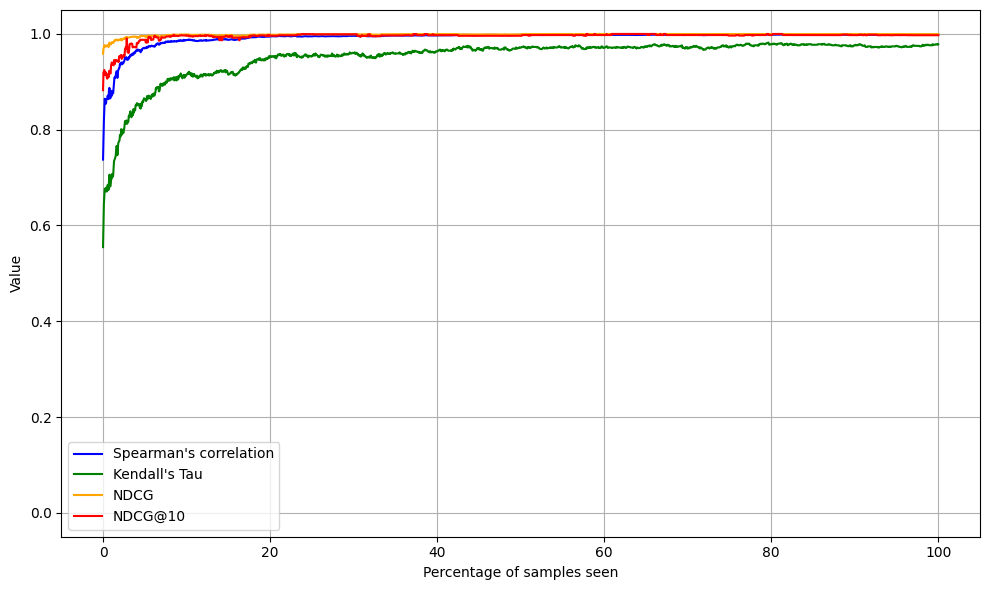

In [43]:

plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values, label="NDCG", color="orange")
plt.plot(x, ndcg10_values, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ropal

In [252]:
with tqdm(total=10000) as pbar:
    while len(remaining_samples) > 0:
        new_samples = 0
        while new_samples < 5:
            worker = sample_worker(expert_probs)
            worker_ranks = [rank for wid, rank in remaining_samples if wid == worker]
            if len(worker_ranks) > 0:
                new_sample = generator.choice(worker_ranks, 1)[0].tolist()
                random_samples.append(new_sample)
                s_tuple = (worker,new_sample)
                remaining_samples.remove((worker,new_sample))
                new_samples += 1
            else:
                continue
        expert_params = choix.lsr_rankings(n_items=n_items, data=random_samples, alpha=1e-2, initial_params=expert_params)
        predicted_ranking_exp = expert_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_exp)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_exp]
        y_score = list(reversed(range(1, len(predicted_ranking_exp) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        percentage = (len(random_samples) / len(expert_df['noisy rank']))*100
        percentages.append(percentage)
        spearman_values.append(spearman_corr)
        kendall_values.append(tau)
        ndcg_values.append(ndcg)
        ndcg10_values.append(ndcg10)
        pbar.update(5)

100%|█████████▉| 9875/9900 [05:01<00:00, 32.73it/s]


KeyboardInterrupt: 

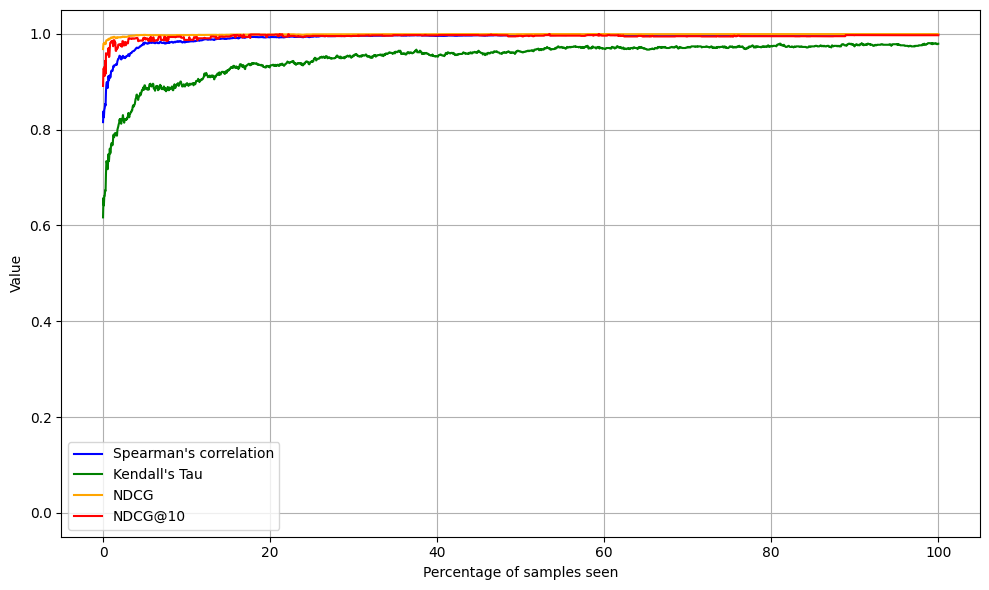

In [253]:
x = np.linspace(0,100, num=len(spearman_values))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values, label="NDCG", color="orange")
plt.plot(x, ndcg10_values, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [265]:
spearman_values_am = []
kendall_values_am = []
ndcg_values_am = []
ndcg10_values_am = []
random_samples = random_sampling(amateur_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in amateur_df.iterrows()
    if row['noisy rank'] not in random_samples
]
amateur_params = choix.lsr_rankings(n_items, data=random_samples, alpha=1e-2)
initial_ranking = amateur_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
tau, p_value_k = kendalltau(true_ranks, pred_ranks)
tau_distance = 1 - tau

y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)

spearman_values_am.append(spearman_corr)
kendall_values_am.append(tau)
ndcg_values_am.append(ndcg)
ndcg10_values_am.append(ndcg10)
print(spearman_values_am)
print(kendall_values_am)
print(ndcg_values_am)
print(ndcg10_values_am)
print(random_samples)

[0.37704918032786894]
[0.2655367231638418]
[0.9072219217851466]
[0.6913550920912205]
[[41, 55, 17], [50, 8, 6], [54, 26, 43], [28, 58, 59], [44, 32, 33], [24, 19, 9], [24, 4, 25], [48, 0, 21], [51, 46, 24], [22, 24, 35], [20, 16, 21], [11, 51, 33], [22, 2, 48], [21, 48, 5], [50, 21, 33], [25, 10, 44], [48, 49, 37], [42, 9, 39], [44, 18, 21], [54, 49, 53], [17, 13, 51], [58, 29, 45], [59, 39, 38], [16, 48, 1], [45, 12, 49], [6, 54, 10], [40, 35, 56], [9, 32, 27], [6, 11, 15], [0, 55, 2], [25, 40, 10], [56, 46, 10], [44, 39, 21], [11, 32, 2], [5, 10, 9], [21, 43, 36], [51, 29, 1], [9, 58, 18], [46, 39, 35], [35, 52, 47], [15, 39, 18], [17, 50, 1], [40, 28, 45], [4, 43, 37], [15, 27, 24], [49, 42, 24], [17, 49, 48], [46, 32, 26], [57, 6, 55], [5, 8, 49], [10, 9, 41], [55, 9, 38], [38, 10, 27], [46, 0, 30], [29, 28, 58], [54, 14, 26], [11, 6, 31], [25, 49, 17], [16, 23, 49], [4, 47, 3], [45, 56, 30], [52, 13, 1], [9, 37, 7], [44, 50, 59], [29, 21, 13], [1, 19, 36], [4, 2, 47], [4, 9, 37], 

In [50]:
while len(remaining_samples) > 0:
    new_samples = random_sampling(remaining_samples, n_samples_per_iter)
    random_samples.extend(new_samples)
    for sample in new_samples:
        remaining_samples.remove(sample)
    amateur_params = choix.lsr_rankings(n_items=n_items, data=random_samples, alpha=1e-2, initial_params=amateur_params)
    predicted_ranking_am = amateur_params.argsort()
    true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_am)
    spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
    tau, p_value_k = kendalltau(true_ranks, pred_ranks)
    tau_distance = 1 - tau

    y_true = [relevance[item] for item in predicted_ranking_am]
    y_score = list(reversed(range(1, len(predicted_ranking_am) + 1)))
    
    y_true = np.asarray([y_true])
    y_score = np.asarray([y_score])
    ndcg = ndcg_score(y_true, y_score)
    ndcg10 = ndcg_score(y_true, y_score, k=10)
    
    spearman_values_am.append(spearman_corr)
    kendall_values_am.append(tau)
    ndcg_values_am.append(ndcg)
    ndcg10_values_am.append(ndcg10)

In [51]:
x = np.linspace(0,100, num=len(spearman_values_am))

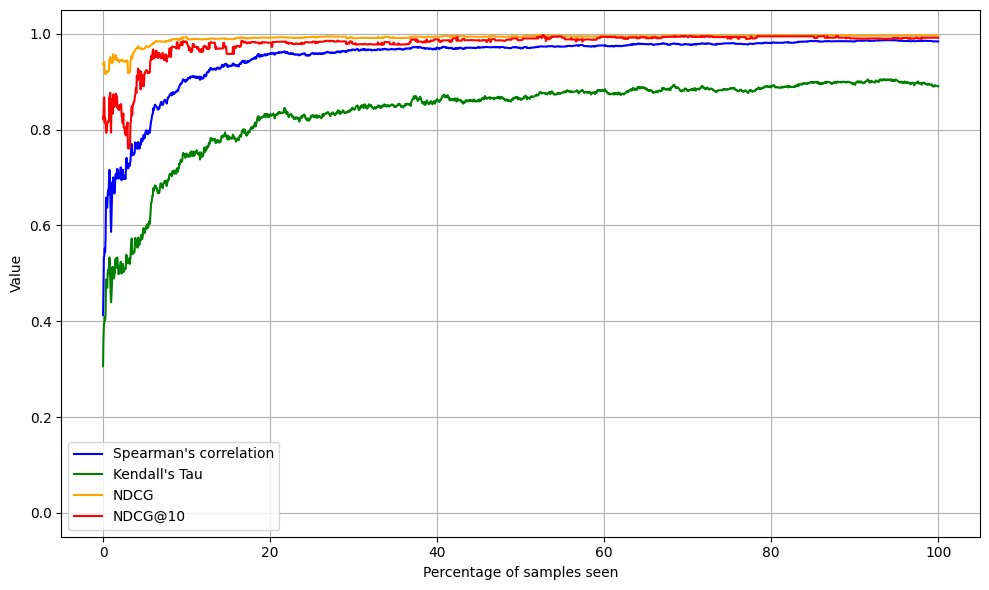

In [52]:

plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_am, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_am, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_am, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_am, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [266]:
with tqdm(total=10000) as pbar:
    while len(remaining_samples) > 0:
        new_samples = 0
        while new_samples < 5:
            worker = sample_worker(amateur_probs)
            worker_ranks = [rank for wid, rank in remaining_samples if wid == worker]
            if len(worker_ranks) > 0:
                new_sample = generator.choice(worker_ranks, 1)[0].tolist()
                random_samples.append(new_sample)
                s_tuple = (worker,new_sample)
                remaining_samples.remove((worker,new_sample))
                new_samples += 1
            else:
                continue
        amateur_params = choix.lsr_rankings(n_items=n_items, data=random_samples, alpha=1e-2, initial_params=amateur_params)
        predicted_ranking_am = amateur_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_am)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_am]
        y_score = list(reversed(range(1, len(predicted_ranking_am) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        percentages.append(percentage)
        spearman_values_am.append(spearman_corr)
        kendall_values_am.append(tau)
        ndcg_values_am.append(ndcg)
        ndcg10_values_am.append(ndcg10)
        pbar.update(5)

 99%|█████████▉| 9890/10000 [03:02<00:02, 54.17it/s]


KeyboardInterrupt: 

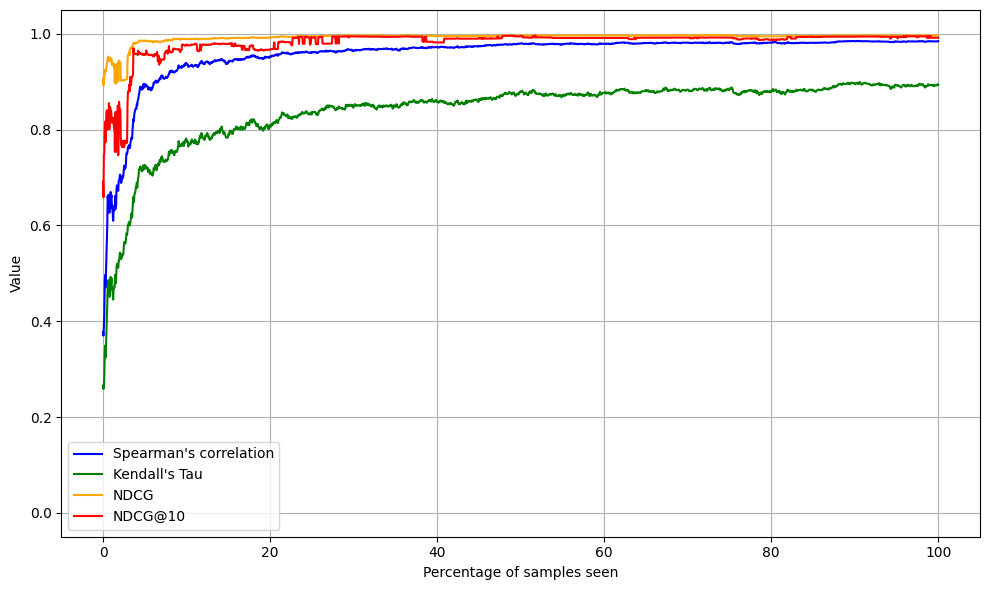

In [267]:
x = np.linspace(0,100, num=len(spearman_values_am))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_am, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_am, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_am, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_am, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [272]:
spearman_values_spm = []
kendall_values_spm = []
ndcg_values_spm = []
ndcg10_values_spm = []
random_samples = random_sampling(spammer_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in spammer_df.iterrows()
    if row['noisy rank'] not in random_samples
]
spammer_params = choix.lsr_rankings(n_items, data=random_samples, alpha=1e-2)
initial_ranking = spammer_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
tau, p_value_k = kendalltau(true_ranks, pred_ranks)
tau_distance = 1 - tau

y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)

spearman_values_spm.append(spearman_corr)
kendall_values_spm.append(tau)
ndcg_values_spm.append(ndcg)
ndcg10_values_spm.append(ndcg10)
print(spearman_values_spm)
print(kendall_values_spm)
print(ndcg_values_spm)
print(ndcg10_values_spm)
print(random_samples)

[0.012392331203111978]
[0.006779661016949152]
[0.864877911928709]
[0.6432750412448982]
[[20, 3, 36], [57, 2, 12], [41, 15, 45], [59, 43, 23], [39, 4, 53], [50, 17, 12], [11, 59, 3], [48, 29, 21], [45, 25, 38], [41, 30, 29], [47, 25, 50], [56, 51, 58], [23, 44, 11], [22, 13, 34], [45, 36, 43], [17, 7, 31], [42, 13, 14], [39, 23, 36], [42, 40, 59], [36, 55, 30], [3, 6, 8], [1, 16, 30], [39, 1, 40], [28, 47, 45], [29, 30, 49], [33, 48, 53], [0, 4, 50], [6, 29, 14], [2, 57, 30], [47, 12, 46], [15, 2, 31], [53, 1, 22], [47, 37, 50], [49, 31, 1], [27, 46, 17], [35, 7, 36], [45, 6, 20], [26, 20, 14], [57, 7, 5], [54, 5, 53], [1, 50, 9], [12, 22, 17], [14, 11, 26], [26, 23, 34], [4, 16, 58], [27, 17, 4], [27, 3, 49], [3, 55, 56], [5, 7, 52], [22, 45, 35], [26, 15, 27], [24, 48, 16], [21, 6, 2], [33, 22, 27], [45, 16, 49], [20, 1, 40], [19, 29, 35], [24, 31, 47], [22, 30, 52], [15, 58, 21], [1, 17, 18], [43, 37, 14], [50, 8, 15], [5, 33, 54], [41, 34, 16], [9, 50, 35], [40, 54, 28], [29, 15, 22

In [54]:
while len(remaining_samples) > 0:

    new_samples = random_sampling(remaining_samples, n_samples_per_iter)
    random_samples.extend(new_samples)
    for sample in new_samples:
        remaining_samples.remove(sample)
    spammer_params = choix.lsr_rankings(n_items=n_items, data=random_samples, alpha=1e-2, initial_params=spammer_params)
    predicted_ranking_spm = spammer_params.argsort()
    true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_spm)
    spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
    tau, p_value_k = kendalltau(true_ranks, pred_ranks)
    tau_distance = 1 - tau

    y_true = [relevance[item] for item in predicted_ranking_spm]
    y_score = list(reversed(range(1, len(predicted_ranking_spm) + 1)))
    
    y_true = np.asarray([y_true])
    y_score = np.asarray([y_score])
    ndcg = ndcg_score(y_true, y_score)
    ndcg10 = ndcg_score(y_true, y_score, k=10)
    
    spearman_values_spm.append(spearman_corr)
    kendall_values_spm.append(tau)
    ndcg_values_spm.append(ndcg)
    ndcg10_values_spm.append(ndcg10)

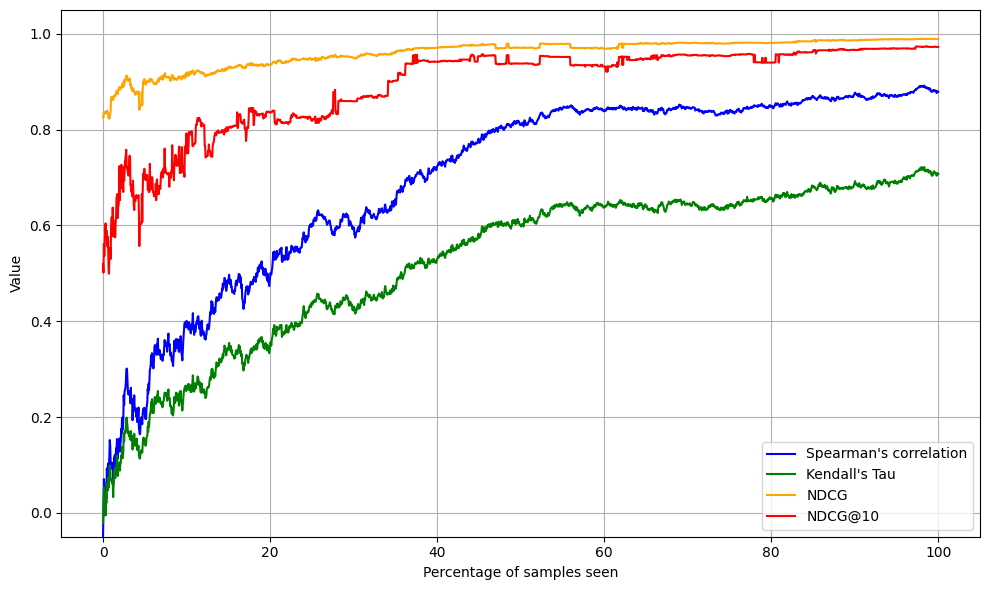

In [55]:
x = np.linspace(0,100, num=len(spearman_values_spm))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_spm, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_spm, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_spm, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_spm, label = "NDCG@10", color="red")
plt.ylim(-0.05, 1.05)
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [273]:
with tqdm(total=10000) as pbar:
    while len(remaining_samples) > 0:
        new_samples = 0
        while new_samples < 5:
            worker = sample_worker(spammer_probs)
            worker_ranks = [rank for wid, rank in remaining_samples if wid == worker]
            if len(worker_ranks) > 0:
                new_sample = generator.choice(worker_ranks, 1)[0].tolist()
                random_samples.append(new_sample)
                s_tuple = (worker,new_sample)
                remaining_samples.remove((worker,new_sample))
                new_samples += 1
            else:
                continue
        spammer_params = choix.lsr_rankings(n_items=n_items, data=random_samples, alpha=1e-2, initial_params=spammer_params)
        predicted_ranking_spm = spammer_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_spm)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_spm]
        y_score = list(reversed(range(1, len(predicted_ranking_spm) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        percentages.append(percentage)
        spearman_values_spm.append(spearman_corr)
        kendall_values_spm.append(tau)
        ndcg_values_spm.append(ndcg)
        ndcg10_values_spm.append(ndcg10)
        pbar.update(5)

 99%|█████████▉| 9885/10000 [02:49<00:01, 58.48it/s]


KeyboardInterrupt: 

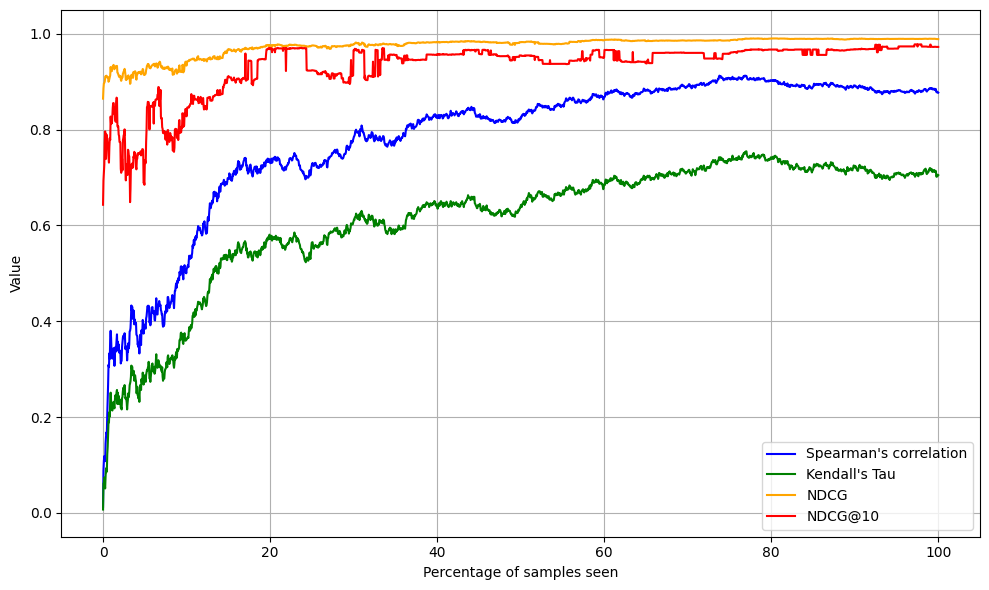

In [274]:
x = np.linspace(0,100, num=len(spearman_values_spm))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_spm, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_spm, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_spm, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_spm, label = "NDCG@10", color="red")
plt.ylim(-0.05, 1.05)
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [276]:
spearman_values_mal = []
kendall_values_mal = []
ndcg_values_mal = []
ndcg10_values_mal = []
random_samples = random_sampling(malicious_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in malicious_df.iterrows()
    if row['noisy rank'] not in random_samples
]

malicious_params = choix.lsr_rankings(n_items, data=random_samples, alpha=1e-2)
initial_ranking = malicious_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
tau, p_value_k = kendalltau(true_ranks, pred_ranks)
tau_distance = 1 - tau

y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)

spearman_values_mal.append(spearman_corr)
kendall_values_mal.append(tau)
ndcg_values_mal.append(ndcg)
ndcg10_values_mal.append(ndcg10)
print(spearman_values_mal)
print(kendall_values_mal)
print(ndcg_values_mal)
print(ndcg10_values_mal)
print(random_samples)

[-0.07829952764656851]
[-0.05649717514124294]
[0.8189322929274808]
[0.47586207838151345]
[[10, 47, 38], [30, 12, 5], [59, 19, 16], [19, 54, 9], [29, 11, 47], [49, 33, 41], [47, 37, 44], [26, 20, 7], [3, 31, 57], [31, 14, 5], [35, 41, 46], [59, 20, 26], [51, 55, 53], [24, 18, 7], [29, 46, 9], [49, 47, 33], [57, 16, 43], [25, 22, 27], [57, 29, 16], [17, 4, 13], [28, 48, 46], [37, 18, 10], [2, 13, 6], [2, 55, 26], [6, 25, 21], [38, 8, 22], [18, 23, 52], [34, 58, 15], [34, 27, 44], [32, 58, 26], [30, 38, 55], [55, 17, 53], [20, 17, 16], [34, 46, 33], [22, 47, 50], [38, 23, 2], [14, 32, 47], [29, 35, 21], [3, 52, 55], [33, 15, 25], [27, 32, 51], [39, 19, 4], [15, 21, 13], [29, 1, 51], [52, 34, 37], [38, 13, 30], [3, 18, 59], [9, 23, 8], [3, 49, 59], [35, 22, 8], [38, 24, 37], [25, 11, 32], [1, 50, 41], [58, 55, 29], [1, 48, 31], [7, 54, 5], [0, 52, 43], [22, 37, 39], [30, 23, 15], [22, 15, 9], [51, 50, 9], [3, 31, 36], [34, 16, 27], [58, 38, 16], [45, 1, 32], [46, 4, 31], [16, 8, 19], [59, 

In [58]:
while len(remaining_samples) > 0:
    
    new_samples = random_sampling(remaining_samples, n_samples_per_iter)
    random_samples.extend(new_samples)
    for sample in new_samples:
        remaining_samples.remove(sample)
    malicious_params = choix.lsr_rankings(n_items=n_items, data=random_samples, alpha=1e-2, initial_params=malicious_params)
    predicted_ranking_mal = malicious_params.argsort()
    true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_mal)
    spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
    tau, p_value_k = kendalltau(true_ranks, pred_ranks)
    tau_distance = 1 - tau

    y_true = [relevance[item] for item in predicted_ranking_mal]
    y_score = list(reversed(range(1, len(predicted_ranking_mal) + 1)))
    
    y_true = np.asarray([y_true])
    y_score = np.asarray([y_score])
    ndcg = ndcg_score(y_true, y_score)
    ndcg10 = ndcg_score(y_true, y_score, k=10)
    
    spearman_values_mal.append(spearman_corr)
    kendall_values_mal.append(tau)
    ndcg_values_mal.append(ndcg)
    ndcg10_values_mal.append(ndcg10)

In [59]:
x = np.linspace(0,100, num=len(spearman_values_mal))

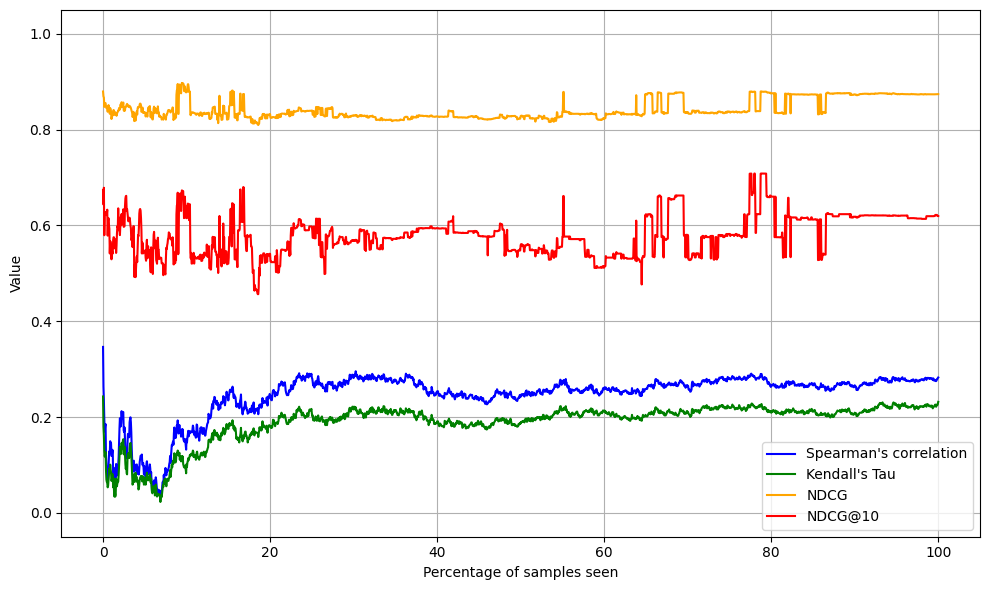

In [60]:

plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_mal, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_mal, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_mal, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_mal, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [277]:
with tqdm(total=10000) as pbar:
    while len(remaining_samples) > 0:
        new_samples = 0
        while new_samples < 5:
            worker = sample_worker(malicious_probs)
            worker_ranks = [rank for wid, rank in remaining_samples if wid == worker]
            if len(worker_ranks) > 0:
                new_sample = generator.choice(worker_ranks, 1)[0].tolist()
                random_samples.append(new_sample)
                s_tuple = (worker,new_sample)
                remaining_samples.remove((worker,new_sample))
                new_samples += 1
            else:
                continue
        malicious_params = choix.lsr_rankings(n_items=n_items, data=random_samples, alpha=1e-2, initial_params=malicious_params)
        predicted_ranking_mal = malicious_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_mal)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_mal]
        y_score = list(reversed(range(1, len(predicted_ranking_mal) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        percentages.append(percentage)
        spearman_values_mal.append(spearman_corr)
        kendall_values_mal.append(tau)
        ndcg_values_mal.append(ndcg)
        ndcg10_values_mal.append(ndcg10)
        pbar.update(5)

 99%|█████████▊| 9870/10000 [02:58<00:02, 55.18it/s]


KeyboardInterrupt: 

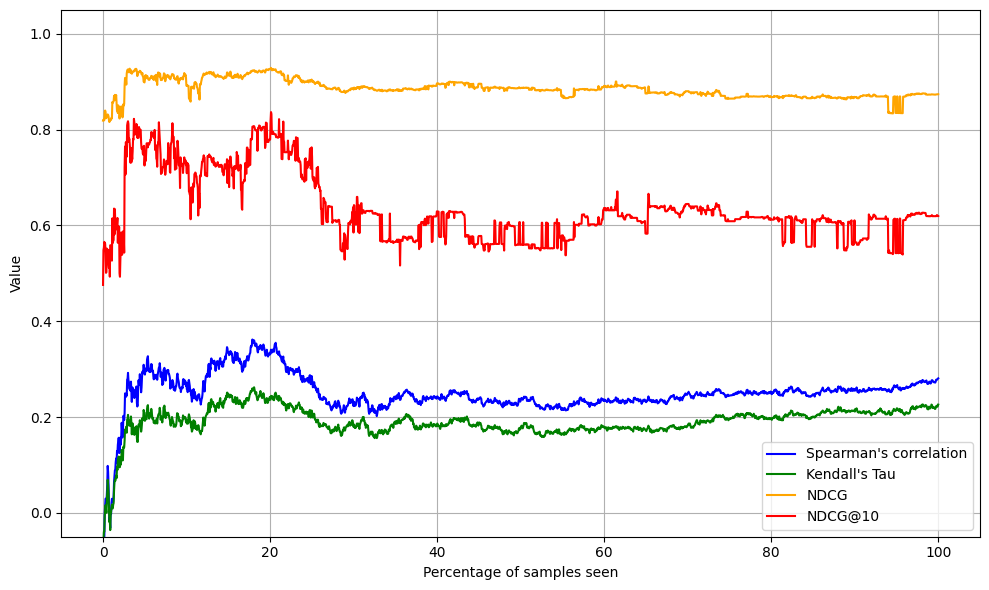

In [278]:
x = np.linspace(0,100, num=len(spearman_values_mal))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_mal, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_mal, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_mal, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_mal, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Uncertainty sampling

In [65]:
def uncertainty_sampling(dataset, n_samples, model_params):
    if len(dataset) < n_samples:
        n_samples = len(dataset)
    model_params = torch.tensor(model_params, dtype=torch.float32, device="cuda")
    samples = torch.tensor(dataset, dtype=torch.int64, device="cuda")
    probs = torch.softmax(model_params[samples], dim=-1)  
    sample_entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=-1)
    top_indices = torch.argsort(sample_entropy, descending=True)[:n_samples]        
    selected_samples = samples[top_indices].cpu().tolist()

    return selected_samples

In [76]:
spearman_values_exp_unc = []
kendall_values_exp_unc = []
ndcg_values_exp_unc = []
ndcg10_values_exp_unc = []
initial_samples = random_sampling(expert_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in expert_df.iterrows()
    if row['noisy rank'] not in initial_samples
]
expert_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2)
initial_ranking = expert_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
tau, p_value_k = kendalltau(true_ranking, initial_ranking)
tau_distance = 1 - tau
y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
    
print(f"Spearman: {spearman_corr}, p_value: {p_value_s}")
print(f"Kendall tau: {tau}, tau distance: {tau_distance}")
spearman_values_exp_unc.append(spearman_corr)
kendall_values_exp_unc.append(tau)
ndcg_values_exp_unc.append(ndcg)
ndcg10_values_exp_unc.append(ndcg10)

Spearman: 0.746874131703251, p_value: 7.275908834143768e-12
Kendall tau: 0.10169491525423728, tau distance: 0.8983050847457628


In [283]:
while len(remaining_samples) > 0:
    new_samples = uncertainty_sampling(remaining_samples, n_items, n_samples_per_iter, expert_params)
    initial_samples.extend(new_samples)
    for sample in new_samples:
        remaining_samples.remove(sample)
    expert_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=expert_params)
    predicted_ranking_exp = expert_params.argsort()
    true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_exp)
    
    spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
    tau, p_value_k = kendalltau(true_ranks, pred_ranks)
    tau_distance = 1 - tau

    y_true = [relevance[item] for item in predicted_ranking_exp]
    y_score = list(reversed(range(1, len(predicted_ranking_exp) + 1)))
    
    y_true = np.asarray([y_true])
    y_score = np.asarray([y_score])
    ndcg = ndcg_score(y_true, y_score)
    ndcg10 = ndcg_score(y_true, y_score, k=10)
    
    spearman_values_exp_unc.append(spearman_corr)
    kendall_values_exp_unc.append(tau)
    ndcg_values_exp_unc.append(ndcg)
    ndcg10_values_exp_unc.append(ndcg10)

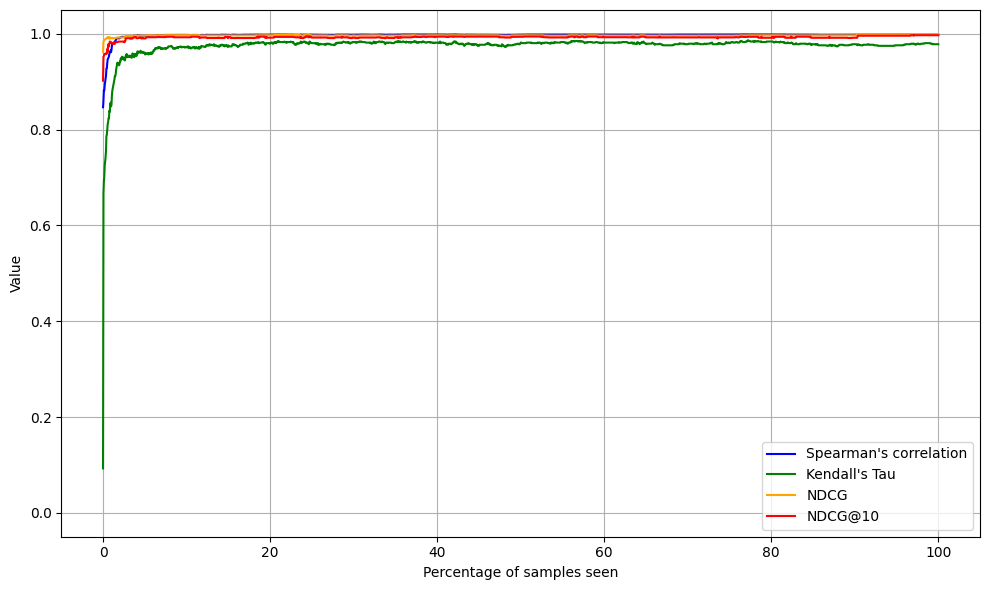

In [284]:
x = np.linspace(0,100, num=len(spearman_values_exp_unc))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_exp_unc, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_exp_unc, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_exp_unc, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_exp_unc, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
with tqdm(total=10000) as pbar:
    while len(remaining_samples) > 0:
        new_samples = 0
        while new_samples < 5:
            worker = sample_worker(expert_probs)
            worker_ranks = [rank for wid, rank in remaining_samples if wid == worker]
            if len(worker_ranks) > 0:
                new_sample = uncertainty_sampling(worker_ranks, 1, expert_params)[0]
                initial_samples.append(new_sample)
                s_tuple = (worker,new_sample)
                remaining_samples.remove(s_tuple)
                new_samples += 1
            else:
                continue
        expert_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=expert_params)
        predicted_ranking_exp = expert_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_exp)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_exp]
        y_score = list(reversed(range(1, len(predicted_ranking_exp) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_exp_unc.append(spearman_corr)
        kendall_values_exp_unc.append(tau)
        ndcg_values_exp_unc.append(ndcg)
        ndcg10_values_exp_unc.append(ndcg10)
        pbar.update(5)

 99%|█████████▉| 9875/10000 [02:29<00:01, 65.85it/s]


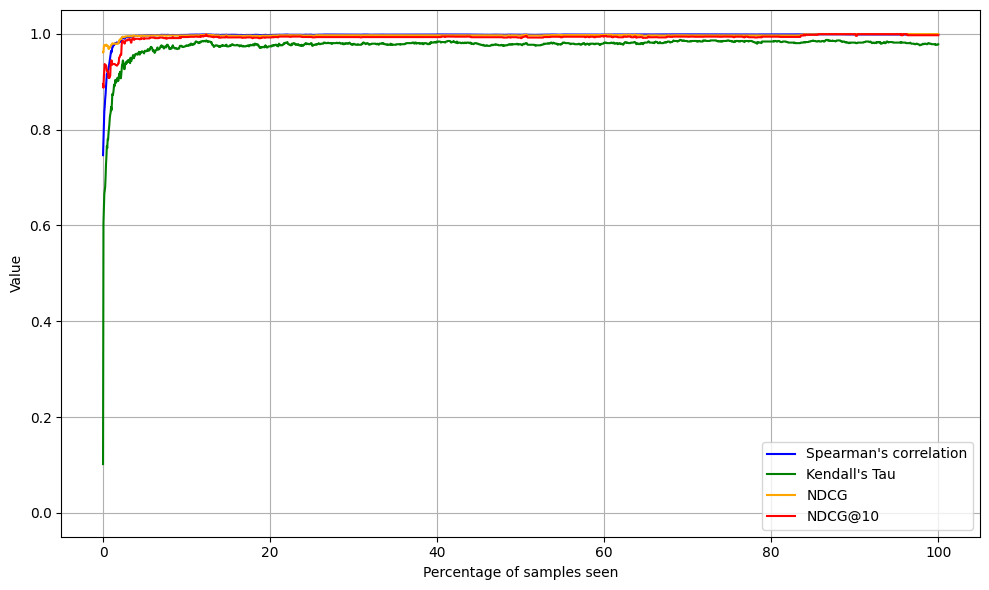

In [78]:
x = np.linspace(0,100, num=len(spearman_values_exp_unc))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_exp_unc, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_exp_unc, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_exp_unc, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_exp_unc, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
spearman_values_am_unc = []
kendall_values_am_unc = []
ndcg_values_am_unc = []
ndcg10_values_am_unc = []
initial_samples = random_sampling(amateur_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in amateur_df.iterrows()
    if row['noisy rank'] not in initial_samples
]
amateur_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2)
initial_ranking = amateur_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
tau, p_value_k = kendalltau(true_ranking, initial_ranking)
tau_distance = 1 - tau
y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
    
print(f"Spearman: {spearman_corr}, p_value: {p_value_s}")
print(f"Kendall tau: {tau}, tau distance: {tau_distance}")
spearman_values_am_unc.append(spearman_corr)
kendall_values_am_unc.append(tau)
ndcg_values_am_unc.append(ndcg)
ndcg10_values_am_unc.append(ndcg10)

Spearman: 0.3371492081133649, p_value: 0.00843299590290574
Kendall tau: -0.1401129943502825, tau distance: 1.1401129943502826


In [97]:
while len(remaining_samples) > 0:
    new_samples = uncertainty_sampling(remaining_samples, n_items, n_samples_per_iter, amateur_params)
    initial_samples.extend(new_samples)
    for sample in new_samples:
        remaining_samples.remove(sample)
    amateur_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=amateur_params)
    predicted_ranking_am = amateur_params.argsort()
    true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_am)
    
    spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
    tau, p_value_k = kendalltau(true_ranks, pred_ranks)
    tau_distance = 1 - tau

    y_true = [relevance[item] for item in predicted_ranking_am]
    y_score = list(reversed(range(1, len(predicted_ranking_am) + 1)))
    
    y_true = np.asarray([y_true])
    y_score = np.asarray([y_score])
    ndcg = ndcg_score(y_true, y_score)
    ndcg10 = ndcg_score(y_true, y_score, k=10)
    
    spearman_values_am_unc.append(spearman_corr)
    kendall_values_am_unc.append(tau)
    ndcg_values_am_unc.append(ndcg)
    ndcg10_values_am_unc.append(ndcg10)

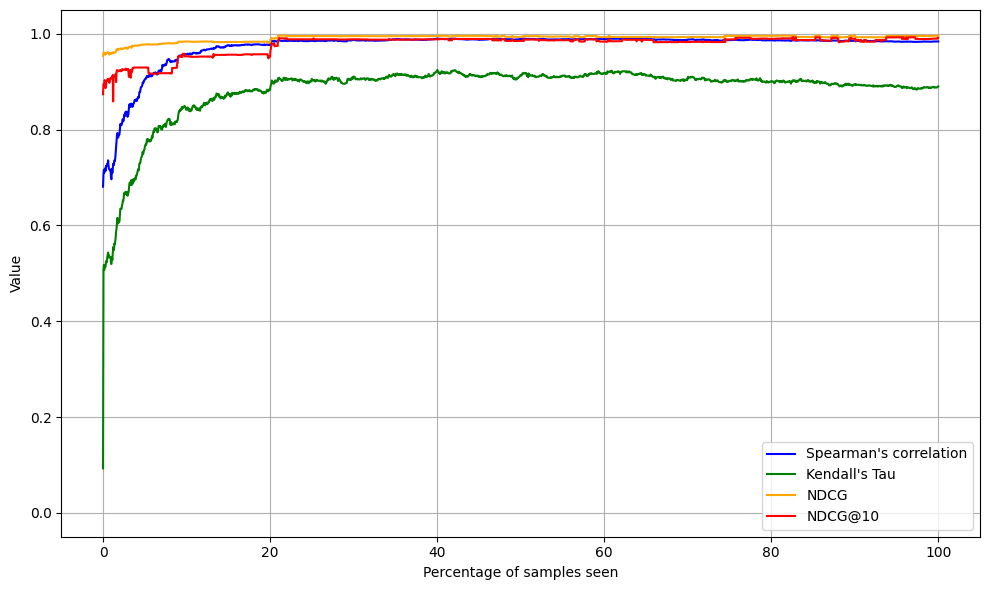

In [98]:
x = np.linspace(0,100, num=len(spearman_values_am_unc))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_am_unc, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_am_unc, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_am_unc, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_am_unc, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
with tqdm(total=10000) as pbar:
    while len(remaining_samples) > 0:
        new_samples = 0
        while new_samples < 5:
            worker = sample_worker(amateur_probs)
            worker_ranks = [rank for wid, rank in remaining_samples if wid == worker]
            if len(worker_ranks) > 0:
                new_sample = uncertainty_sampling(worker_ranks, 1, amateur_params)[0]
                initial_samples.append(new_sample)
                s_tuple = (worker,new_sample)
                remaining_samples.remove(s_tuple)
                new_samples += 1
            else:
                continue
        amateur_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=amateur_params)
        predicted_ranking_am = amateur_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_am)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_am]
        y_score = list(reversed(range(1, len(predicted_ranking_am) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_am_unc.append(spearman_corr)
        kendall_values_am_unc.append(tau)
        ndcg_values_am_unc.append(ndcg)
        ndcg10_values_am_unc.append(ndcg10)
        pbar.update(5)

 99%|█████████▉| 9890/10000 [02:29<00:01, 66.15it/s]


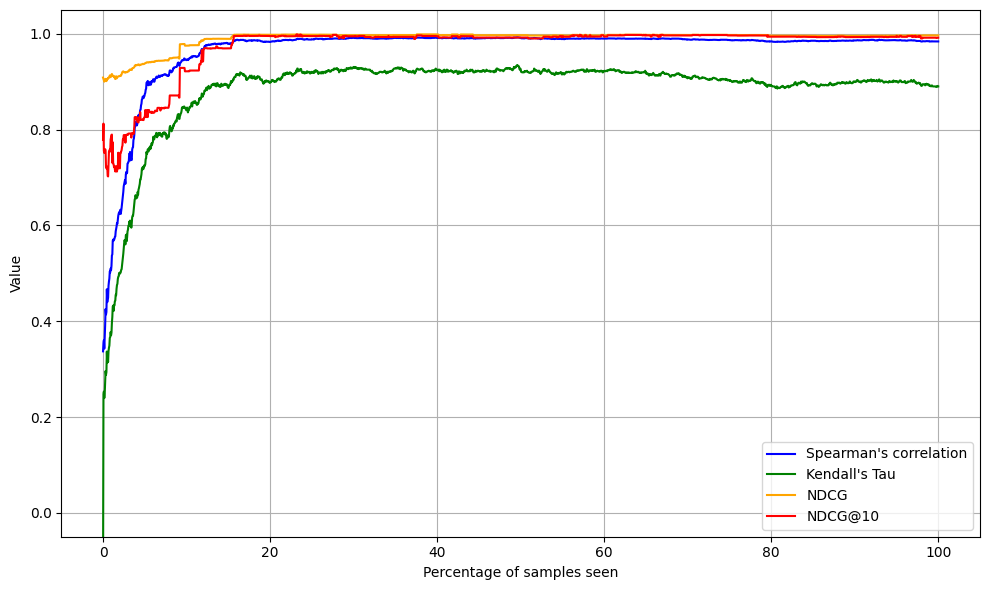

In [84]:
x = np.linspace(0,100, num=len(spearman_values_am_unc))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_am_unc, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_am_unc, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_am_unc, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_am_unc, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [85]:
spearman_values_spm_unc = []
kendall_values_spm_unc = []
ndcg_values_spm_unc = []
ndcg10_values_spm_unc = []
initial_samples = random_sampling(spammer_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in spammer_df.iterrows()
    if row['noisy rank'] not in initial_samples
]
spammer_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2)
initial_ranking = spammer_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
tau, p_value_k = kendalltau(true_ranking, initial_ranking)
tau_distance = 1 - tau
y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
    
print(f"Spearman: {spearman_corr}, p_value: {p_value_s}")
print(f"Kendall tau: {tau}, tau distance: {tau_distance}")
spearman_values_spm_unc.append(spearman_corr)
kendall_values_spm_unc.append(tau)
ndcg_values_spm_unc.append(ndcg)
ndcg10_values_spm_unc.append(ndcg10)

Spearman: 0.11580994720755768, p_value: 0.3782315210543634
Kendall tau: 0.06101694915254237, tau distance: 0.9389830508474576


In [100]:
while len(remaining_samples) > 0:
    new_samples = uncertainty_sampling(remaining_samples, n_items, n_samples_per_iter, spammer_params)
    initial_samples.extend(new_samples)
    for sample in new_samples:
        remaining_samples.remove(sample)
    spammer_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=spammer_params)
    predicted_ranking_spm = spammer_params.argsort()
    true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_spm)
    
    spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
    tau, p_value_k = kendalltau(true_ranks, pred_ranks)
    tau_distance = 1 - tau

    y_true = [relevance[item] for item in predicted_ranking_spm]
    y_score = list(reversed(range(1, len(predicted_ranking_spm) + 1)))
    
    y_true = np.asarray([y_true])
    y_score = np.asarray([y_score])
    ndcg = ndcg_score(y_true, y_score)
    ndcg10 = ndcg_score(y_true, y_score, k=10)
    
    spearman_values_spm_unc.append(spearman_corr)
    kendall_values_spm_unc.append(tau)
    ndcg_values_spm_unc.append(ndcg)
    ndcg10_values_spm_unc.append(ndcg10)

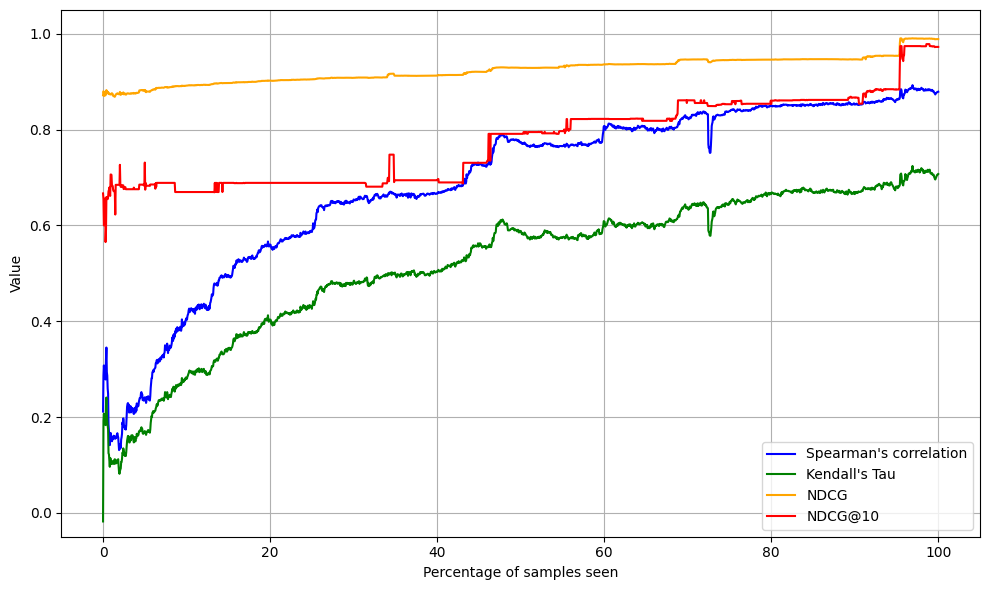

In [101]:
x = np.linspace(0,100, num=len(spearman_values_spm_unc))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_spm_unc, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_spm_unc, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_spm_unc, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_spm_unc, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [86]:
with tqdm(total=10000) as pbar:
    while len(remaining_samples) > 0:
        new_samples = 0
        while new_samples < 5:
            worker = sample_worker(spammer_probs)
            worker_ranks = [rank for wid, rank in remaining_samples if wid == worker]
            if len(worker_ranks) > 0:
                new_sample = uncertainty_sampling(worker_ranks, 1, spammer_params)[0]
                initial_samples.append(new_sample)
                s_tuple = (worker,new_sample)
                remaining_samples.remove(s_tuple)
                new_samples += 1
            else:
                continue
        spammer_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=spammer_params)
        predicted_ranking_spm = spammer_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_spm)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_spm]
        y_score = list(reversed(range(1, len(predicted_ranking_spm) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_spm_unc.append(spearman_corr)
        kendall_values_spm_unc.append(tau)
        ndcg_values_spm_unc.append(ndcg)
        ndcg10_values_spm_unc.append(ndcg10)
        pbar.update(5)

 99%|█████████▉| 9890/10000 [02:54<00:01, 56.71it/s]


KeyboardInterrupt: 

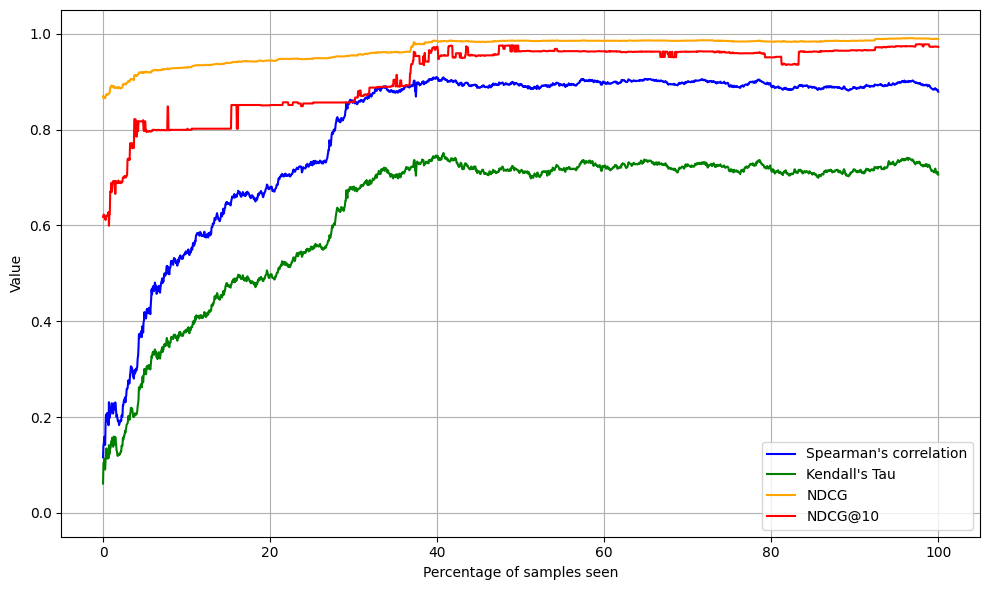

In [87]:
x = np.linspace(0,100, num=len(spearman_values_spm_unc))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_spm_unc, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_spm_unc, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_spm_unc, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_spm_unc, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [88]:
spearman_values_mal_unc = []
kendall_values_mal_unc = []
ndcg_values_mal_unc = []
ndcg10_values_mal_unc = []
initial_samples = random_sampling(malicious_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in malicious_df.iterrows()
    if row['noisy rank'] not in initial_samples
]
malicious_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2)
initial_ranking = malicious_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
tau, p_value_k = kendalltau(true_ranking, initial_ranking)
tau_distance = 1 - tau
y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
    
print(f"Spearman: {spearman_corr}, p_value: {p_value_s}")
print(f"Kendall tau: {tau}, tau distance: {tau_distance}")
spearman_values_mal_unc.append(spearman_corr)
kendall_values_mal_unc.append(tau)
ndcg_values_mal_unc.append(ndcg)
ndcg10_values_mal_unc.append(ndcg10)

Spearman: 0.042178382884134495, p_value: 0.7489819284798357
Kendall tau: -0.10169491525423728, tau distance: 1.1016949152542372


In [103]:
while len(remaining_samples) > 0:
    new_samples = uncertainty_sampling(remaining_samples, n_items, n_samples_per_iter, malicious_params)
    initial_samples.extend(new_samples)
    for sample in new_samples:
        remaining_samples.remove(sample)
    malicious_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=malicious_params)
    predicted_ranking_mal = malicious_params.argsort()
    true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_mal)
    
    spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
    tau, p_value_k = kendalltau(true_ranks, pred_ranks)
    tau_distance = 1 - tau

    y_true = [relevance[item] for item in predicted_ranking_mal]
    y_score = list(reversed(range(1, len(predicted_ranking_mal) + 1)))
    
    y_true = np.asarray([y_true])
    y_score = np.asarray([y_score])
    ndcg = ndcg_score(y_true, y_score)
    ndcg10 = ndcg_score(y_true, y_score, k=10)
    
    spearman_values_mal_unc.append(spearman_corr)
    kendall_values_mal_unc.append(tau)
    ndcg_values_mal_unc.append(ndcg)
    ndcg10_values_mal_unc.append(ndcg10)

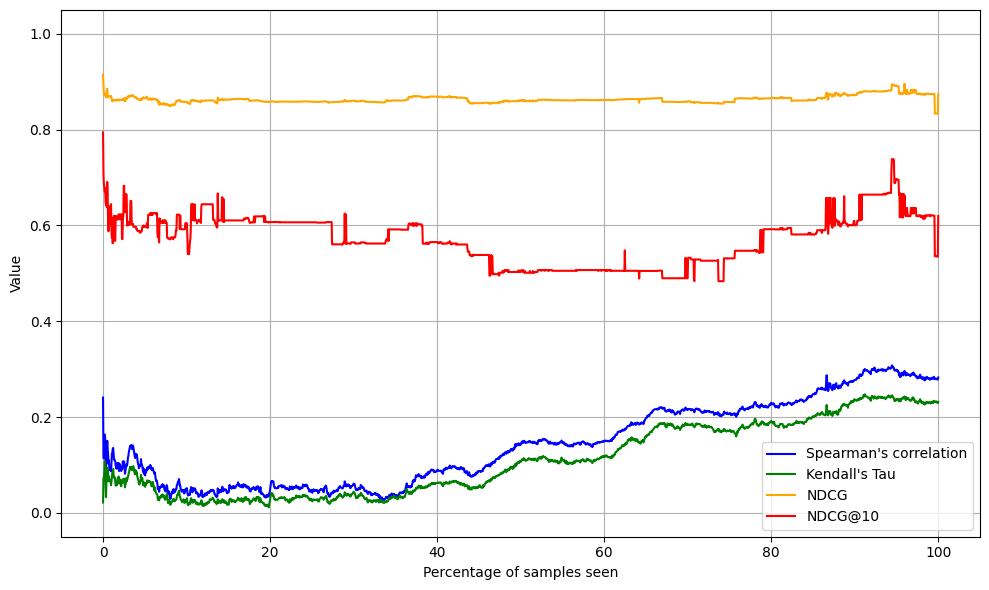

In [104]:
x = np.linspace(0,100, num=len(spearman_values_mal_unc))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_mal_unc, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_mal_unc, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_mal_unc, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_mal_unc, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [89]:
with tqdm(total=10000) as pbar:
    while len(remaining_samples) > 0:
        new_samples = 0
        while new_samples < 5:
            worker = sample_worker(malicious_probs)
            worker_ranks = [rank for wid, rank in remaining_samples if wid == worker]
            if len(worker_ranks) > 0:
                new_sample = uncertainty_sampling(worker_ranks, 1, malicious_params)[0]
                initial_samples.append(new_sample)
                s_tuple = (worker,new_sample)
                remaining_samples.remove(s_tuple)
                new_samples += 1
            else:
                continue
        malicious_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=malicious_params)
        predicted_ranking_mal = malicious_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_mal)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_mal]
        y_score = list(reversed(range(1, len(predicted_ranking_mal) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_mal_unc.append(spearman_corr)
        kendall_values_mal_unc.append(tau)
        ndcg_values_mal_unc.append(ndcg)
        ndcg10_values_mal_unc.append(ndcg10)
        pbar.update(5)

 99%|█████████▉| 9875/10000 [02:30<00:01, 65.81it/s]


KeyboardInterrupt: 

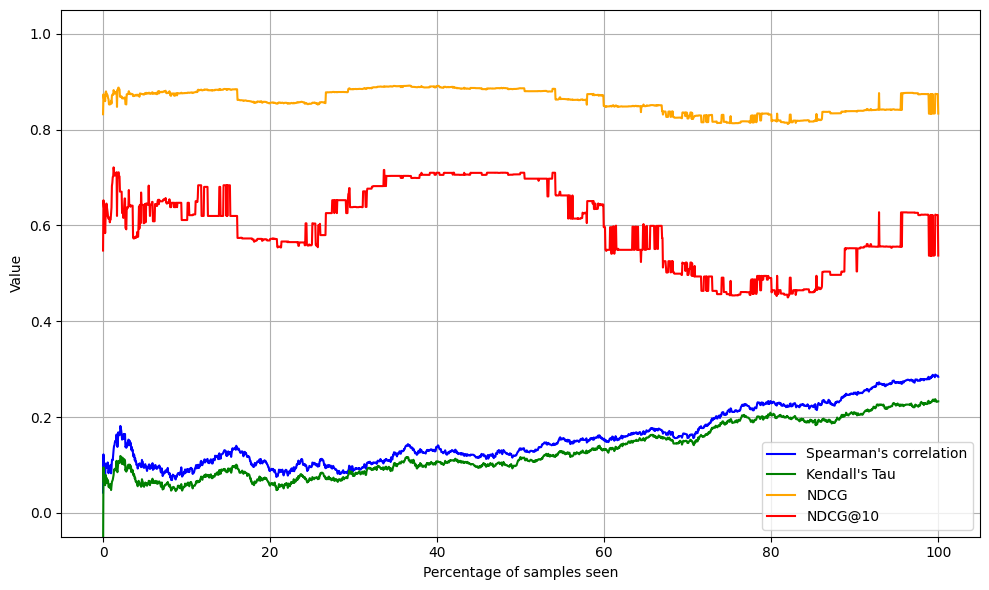

In [90]:
x = np.linspace(0,100, num=len(spearman_values_mal_unc))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_mal_unc, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_mal_unc, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_mal_unc, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_mal_unc, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Similarity sampling

In [286]:
def similarity_sampling(dataset, n_samples, model_params):
    true_rank_dict = {item: rank for rank, item in enumerate(true_ranking)}
    spearman_scores = []

    for sample in dataset:
        # Get model scores for the sample
        sample_scores = [model_params[i] for i in sample]
        pred_ranks = np.argsort(np.argsort(sample_scores))

        # Get true ranks using dict
        try:
            true_ranks = [true_rank_dict[i] for i in sample]
        except KeyError:
            spearman_scores.append(0.0)
            continue

        # Spearman correlation
        corr, _ = spearmanr(pred_ranks, true_ranks)
        if corr is None or np.isnan(corr):
            corr = 0.0
        spearman_scores.append(abs(corr))

    # Sort by lowest correlation (most dissimilar)
    ranked_samples = [x for _, x in sorted(zip(spearman_scores, dataset), key=lambda pair: pair[0])]
    return ranked_samples[:n_samples]

In [290]:
spearman_values_exp_sim = []
kendall_values_exp_sim = []
ndcg_values_exp_sim = []
ndcg10_values_exp_sim = []
initial_samples = random_sampling(expert_df['noisy rank'], n_initial_samples)
remaining_samples = [s for s in expert_df['noisy rank']]
for sample in initial_samples:
    remaining_samples.remove(sample)
expert_params_sim = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2)
initial_ranking = expert_params_sim.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr, _= spearmanr(true_ranks, pred_ranks)
tau, _ = kendalltau(true_ranks, pred_ranks)
y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
print(f"Spearman: {spearman_corr}, p_value: {p_value_s}")
print(f"Kendall tau: {tau}, tau distance: {tau_distance}")
spearman_values_exp_sim.append(spearman_corr)
kendall_values_exp_sim.append(tau)
ndcg_values_exp_sim.append(ndcg)
ndcg10_values_exp_sim.append(ndcg10)

Spearman: 0.821005834954154, p_value: 7.601732611410248e-76
Kendall tau: 0.6135593220338983, tau distance: 0.021468926553672274


In [291]:
with tqdm(total=9900) as pbar:

    while len(remaining_samples)>0:
        new_samples = similarity_sampling(remaining_samples, n_samples_per_iter, expert_params_sim)
        
        initial_samples.extend(new_samples)
        for sample in new_samples:
            remaining_samples.remove(sample)
        expert_params_sim = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=expert_params_sim)
        predicted_ranking_exp = expert_params_sim.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_exp)
        spearman_corr, _= spearmanr(true_ranks, pred_ranks)
        tau, _ = kendalltau(true_ranks, pred_ranks)
        y_true = [relevance[item] for item in predicted_ranking_exp]
        y_score = list(reversed(range(1, len(predicted_ranking_exp) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
    
        spearman_values_exp_sim.append(spearman_corr)
        kendall_values_exp_sim.append(tau)
        ndcg_values_exp_sim.append(ndcg)
        ndcg10_values_exp_sim.append(ndcg10)
        pbar.update(n_samples_per_iter)

  0%|          | 30/9900 [01:10<6:28:20,  2.36s/it]


KeyboardInterrupt: 

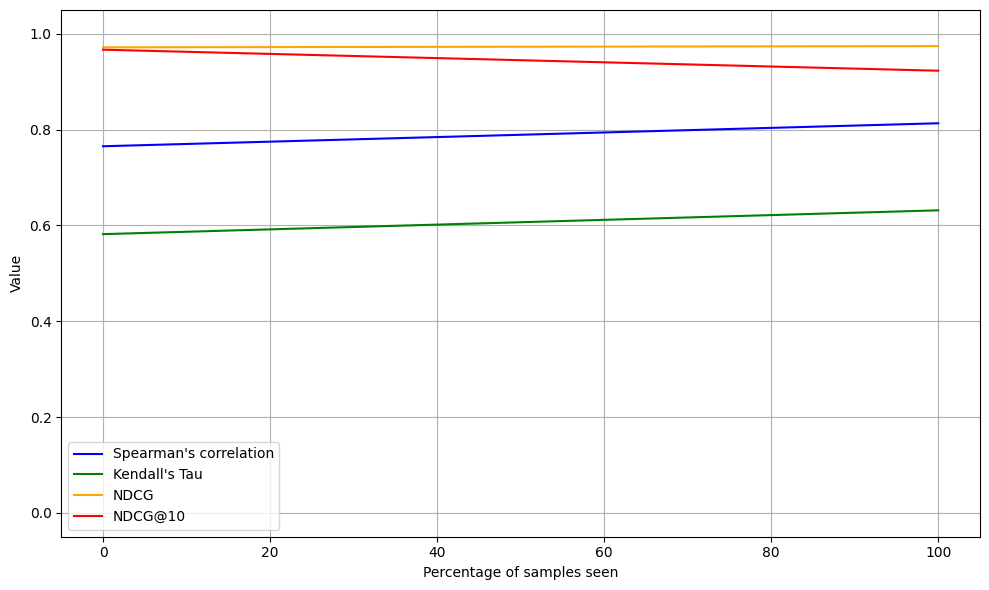

In [289]:
x = np.linspace(0,100, num=len(spearman_values_exp_sim))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_exp_sim, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_exp_sim, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_exp_sim, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_exp_sim, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [122]:
spearman_values_am_sim = []
kendall_values_am_sim = []
ndcg_values_am_sim = []
ndcg10_values_am_sim = []
initial_samples = random_sampling(amateur_df['noisy rank'], n_initial_samples)
remaining_samples = [s for s in amateur_df['noisy rank']]
for sample in initial_samples:
    remaining_samples.remove(sample)
expert_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2)
initial_ranking = expert_params.argsort()
spearman_corr, p_value_s = spearmanr(true_ranking, initial_ranking)
tau, p_value_k = kendalltau(true_ranking, initial_ranking)
tau_distance = 1 - tau
y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
print(f"Spearman: {spearman_corr}, p_value: {p_value_s}")
print(f"Kendall tau: {tau}, tau distance: {tau_distance}")
spearman_values_exp_sim.append(spearman_corr)
kendall_values_exp_sim.append(tau)
ndcg_values_exp_sim.append(ndcg)
ndcg10_values_exp_sim.append(ndcg10)

Spearman: 0.019116421228118925, p_value: 0.884731837196763
Kendall tau: 0.021468926553672316, tau distance: 0.9785310734463277


# 1. Diversity sampling
* find most diverse response -> most information not yet seen
* low activation in logits / hidden layers (lack of information)
* difference to uncertainty (conflicting information)
* between pred probs (falcun)

In [91]:
spearman_values_exp_div = []
kendall_values_exp_div = []
ndcg_values_exp_div = []
ndcg10_values_exp_div = []
initial_samples = random_sampling(expert_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in expert_df.iterrows()
    if row['noisy rank'] not in initial_samples
]
expert_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2)
initial_ranking = expert_params.argsort()
spearman_corr, p_value_s = spearmanr(true_ranking, initial_ranking)
tau, p_value_k = kendalltau(true_ranking, initial_ranking)
tau_distance = 1 - tau

y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
spearman_values_exp_div.append(spearman_corr)
kendall_values_exp_div.append(tau)
ndcg_values_exp_div.append(ndcg)
ndcg10_values_exp_div.append(ndcg10)

In [92]:
def margin_uncertainty(sample, params):
    probabilities = choix.probabilities(sample, params)
    probabilities_ab = choix.probabilities([sample[0],sample[1]], params)
    probabilities_ac = choix.probabilities([sample[0],sample[2]], params)
    probabilities_bc = choix.probabilities([sample[1],sample[2]], params)
    prob_abc = probabilities[0] * probabilities_bc[0]
    prob_acb = probabilities[0] * probabilities_bc[1]
    prob_bac = probabilities[1] * probabilities_ac[0]
    prob_bca = probabilities[1] * probabilities_ac[1]
    prob_cab = probabilities[2] * probabilities_ab[0]
    prob_cba = probabilities[2] * probabilities_ab[1]
    max2 = sorted([prob_abc, prob_acb, prob_bac, prob_bca, prob_cab, prob_cba], reverse=True)[:2]
    return abs(max2[0]-max2[1])

In [93]:
def margin_uncertainty_sampling(data, n_samples, params):
    margins = []
    for sample in data:
        margins.append((sample,margin_uncertainty(sample, params)))
    margins.sort(key=lambda x:x[1])
    selected_samples = [sample for sample,_ in margins[:n_samples]]
    return selected_samples

In [97]:
spearman_values_exp = []
kendall_values_exp = []
ndcg_values_exp = []
ndcg10_values_exp = []
initial_samples = random_sampling(expert_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in expert_df.iterrows()
    if row['noisy rank'] not in initial_samples
]
expert_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2)
initial_ranking = expert_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr,_ = spearmanr(true_ranks, pred_ranks)
tau, _ = kendalltau(true_ranks, pred_ranks)

y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
spearman_values_exp.append(spearman_corr)
kendall_values_exp.append(tau)
ndcg_values_exp.append(ndcg)
ndcg10_values_exp.append(ndcg10)

In [232]:
with tqdm(total=9900) as pbar:

    while len(remaining_samples)>0:
        new_samples = margin_uncertainty_sampling(remaining_samples, n_samples_per_iter, expert_params)
        
        initial_samples.extend(new_samples)
        for sample in new_samples:
            remaining_samples.remove(sample)
        expert_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=expert_params)
        predicted_ranking_exp = expert_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_exp)
        spearman_corr, _= spearmanr(true_ranks, pred_ranks)
        tau, _ = kendalltau(true_ranks, pred_ranks)
        y_true = [relevance[item] for item in predicted_ranking_exp]
        y_score = list(reversed(range(1, len(predicted_ranking_exp) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
    
        spearman_values_exp.append(spearman_corr)
        kendall_values_exp.append(tau)
        ndcg_values_exp.append(ndcg)
        ndcg10_values_exp.append(ndcg10)
        pbar.update(5)

100%|██████████| 9900/9900 [08:46<00:00, 18.80it/s]


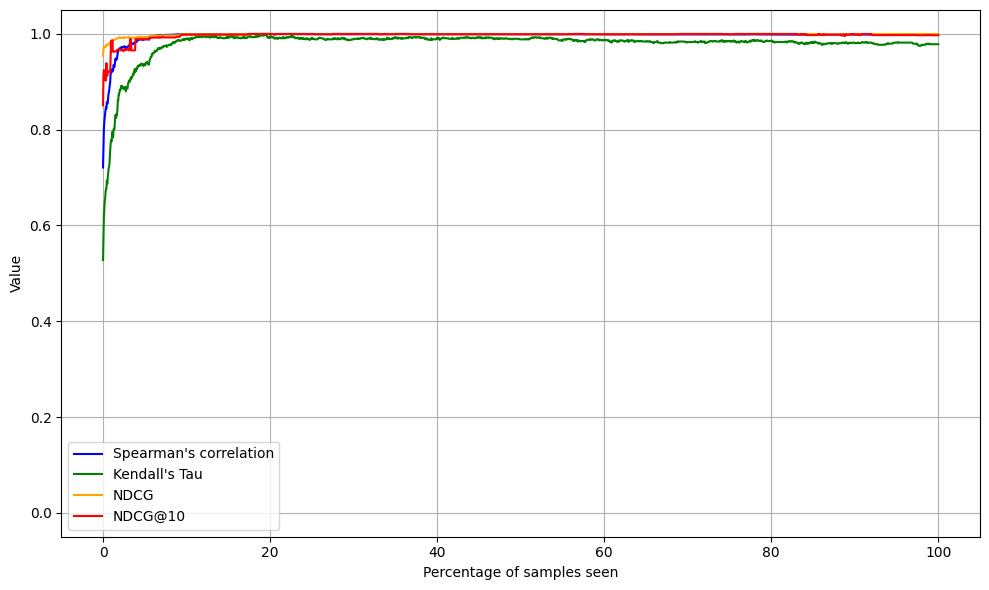

In [233]:
x = np.linspace(0,100, num=len(spearman_values_exp))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values, label="NDCG", color="orange")
plt.plot(x, ndcg10_values, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [98]:
with tqdm(total=10000) as pbar:
    while len(remaining_samples) > 0:
        new_samples = 0
        while new_samples < 5:
            worker = sample_worker(expert_probs)
            worker_ranks = [rank for wid, rank in remaining_samples if wid == worker]
            if len(worker_ranks) > 0:
                new_sample = margin_uncertainty_sampling(worker_ranks, 1, expert_params)[0]
                initial_samples.append(new_sample)
                s_tuple = (worker,new_sample)
                remaining_samples.remove(s_tuple)
                new_samples += 1
            else:
                continue
        expert_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=expert_params)
        predicted_ranking_exp = expert_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_exp)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_exp]
        y_score = list(reversed(range(1, len(predicted_ranking_exp) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_exp.append(spearman_corr)
        kendall_values_exp.append(tau)
        ndcg_values_exp.append(ndcg)
        ndcg10_values_exp.append(ndcg10)
        pbar.update(5)

 99%|█████████▉| 9880/10000 [03:00<00:02, 54.82it/s]


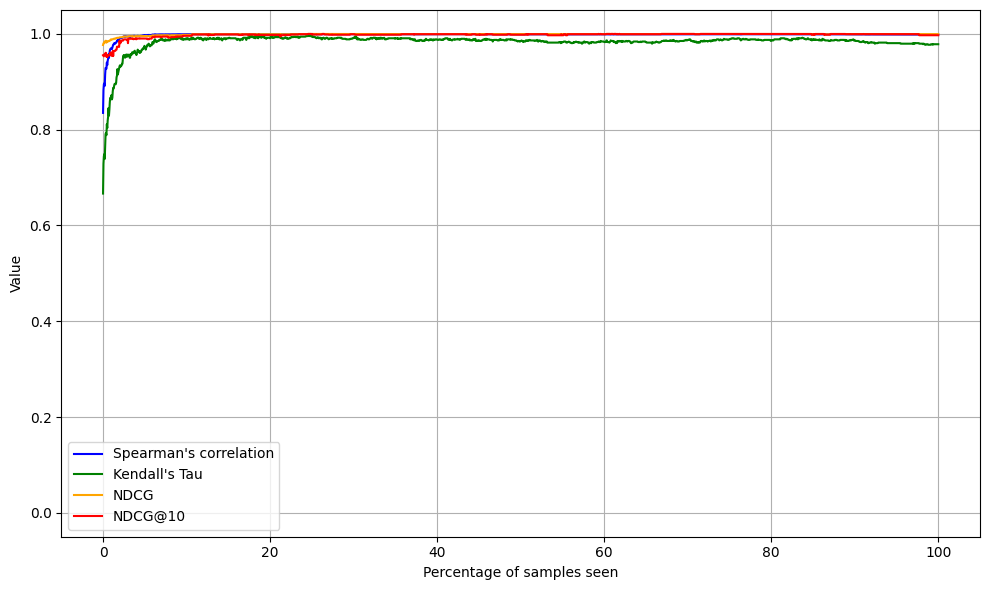

In [99]:
x = np.linspace(0,100, num=len(spearman_values_exp))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_exp, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_exp, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_exp, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_exp, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [102]:
spearman_values_am = []
kendall_values_am = []
ndcg_values_am = []
ndcg10_values_am = []
initial_samples = random_sampling(amateur_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in amateur_df.iterrows()
    if row['noisy rank'] not in initial_samples
]
amateur_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2)
initial_ranking = amateur_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr,_ = spearmanr(true_ranks, pred_ranks)
tau, _ = kendalltau(true_ranks, pred_ranks)
tau_distance = 1 - tau

y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
spearman_values_am.append(spearman_corr)
kendall_values_am.append(tau)
ndcg_values_am.append(ndcg)
ndcg10_values_am.append(ndcg10)

In [262]:
with tqdm(total=9900) as pbar:

    while len(remaining_samples)>0:
        new_samples = margin_uncertainty_sampling(remaining_samples, n_samples_per_iter, amateur_params)
        
        initial_samples.extend(new_samples)
        for sample in new_samples:
            remaining_samples.remove(sample)
        amateur_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=amateur_params)
        predicted_ranking_am = amateur_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_am)
        spearman_corr, _= spearmanr(true_ranks, pred_ranks)
        tau, _ = kendalltau(true_ranks, pred_ranks)
        y_true = [relevance[item] for item in predicted_ranking_am]
        y_score = list(reversed(range(1, len(predicted_ranking_am) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
    
        spearman_values_am.append(spearman_corr)
        kendall_values_am.append(tau)
        ndcg_values_am.append(ndcg)
        ndcg10_values_am.append(ndcg10)
        pbar.update(5)

100%|██████████| 9900/9900 [08:42<00:00, 18.95it/s] 


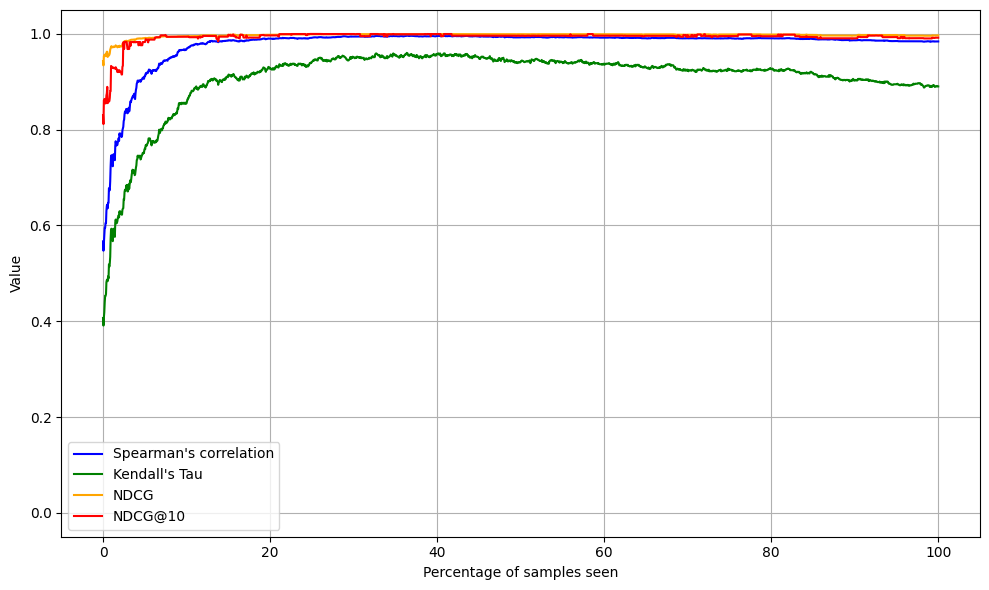

In [263]:
x = np.linspace(0,100, num=len(spearman_values_am))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_am, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_am, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_am, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_am, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [103]:
with tqdm(total=10000) as pbar:
    while len(remaining_samples) > 0:
        new_samples = 0
        while new_samples < 5:
            worker = sample_worker(amateur_probs)
            worker_ranks = [rank for wid, rank in remaining_samples if wid == worker]
            if len(worker_ranks) > 0:
                new_sample = margin_uncertainty_sampling(worker_ranks, 1, amateur_params)[0]
                initial_samples.append(new_sample)
                s_tuple = (worker,new_sample)
                remaining_samples.remove(s_tuple)
                new_samples += 1
            else:
                continue
        amateur_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=amateur_params)
        predicted_ranking_am = amateur_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_am)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_am]
        y_score = list(reversed(range(1, len(predicted_ranking_am) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_am.append(spearman_corr)
        kendall_values_am.append(tau)
        ndcg_values_am.append(ndcg)
        ndcg10_values_am.append(ndcg10)
        pbar.update(5)

 99%|█████████▉| 9895/10000 [02:46<00:01, 59.30it/s]


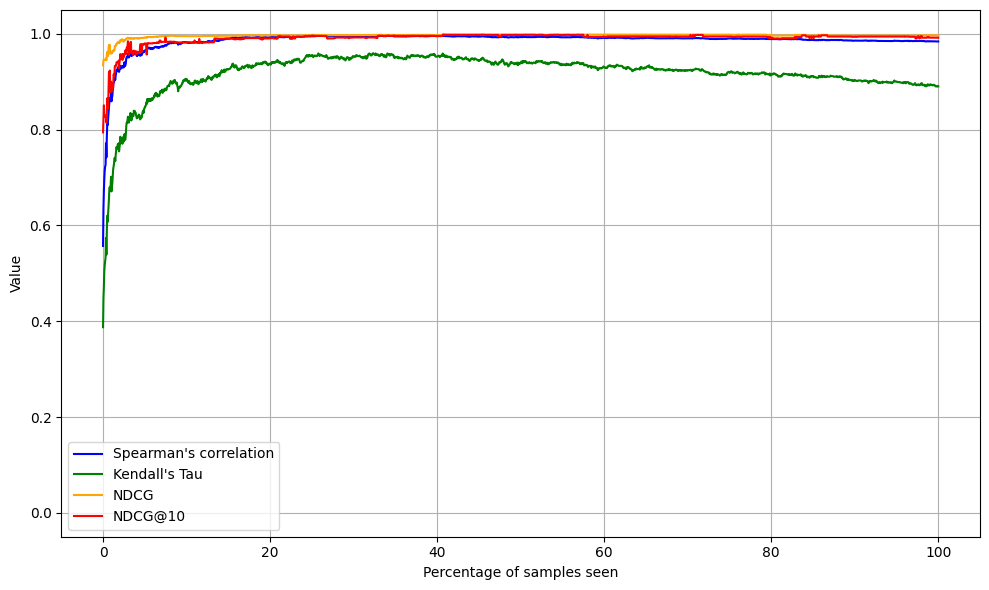

In [104]:
x = np.linspace(0,100, num=len(spearman_values_am))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_am, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_am, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_am, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_am, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [105]:
spearman_values_spm = []
kendall_values_spm = []
ndcg_values_spm = []
ndcg10_values_spm = []
initial_samples = random_sampling(spammer_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in spammer_df.iterrows()
    if row['noisy rank'] not in initial_samples
]
spammer_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2)
initial_ranking = spammer_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr,_ = spearmanr(true_ranks, pred_ranks)
tau, _ = kendalltau(true_ranks, pred_ranks)
tau_distance = 1 - tau

y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
spearman_values_spm.append(spearman_corr)
kendall_values_spm.append(tau)
ndcg_values_spm.append(ndcg)
ndcg10_values_spm.append(ndcg10)

In [265]:
with tqdm(total=9900) as pbar:

    while len(remaining_samples)>0:
        new_samples = margin_uncertainty_sampling(remaining_samples, n_samples_per_iter, spammer_params)
        
        initial_samples.extend(new_samples)
        for sample in new_samples:
            remaining_samples.remove(sample)
        spammer_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=spammer_params)
        predicted_ranking_spm = spammer_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_spm)
        spearman_corr, _= spearmanr(true_ranks, pred_ranks)
        tau, _ = kendalltau(true_ranks, pred_ranks)
        y_true = [relevance[item] for item in predicted_ranking_spm]
        y_score = list(reversed(range(1, len(predicted_ranking_spm) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
    
        spearman_values_spm.append(spearman_corr)
        kendall_values_spm.append(tau)
        ndcg_values_spm.append(ndcg)
        ndcg10_values_spm.append(ndcg10)
        pbar.update(5)

100%|██████████| 9900/9900 [08:41<00:00, 18.97it/s]


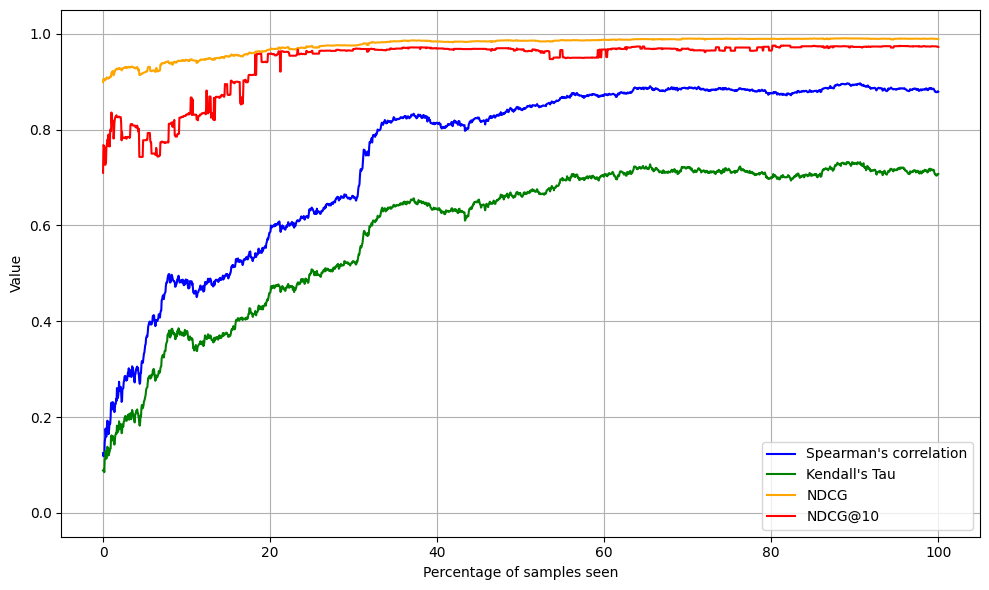

In [266]:
x = np.linspace(0,100, num=len(spearman_values_spm))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_spm, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_spm, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_spm, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_spm, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [106]:
with tqdm(total=10000) as pbar:
    while len(remaining_samples) > 0:
        new_samples = 0
        while new_samples < 5:
            worker = sample_worker(spammer_probs)
            worker_ranks = [rank for wid, rank in remaining_samples if wid == worker]
            if len(worker_ranks) > 0:
                new_sample = margin_uncertainty_sampling(worker_ranks, 1, spammer_params)[0]
                initial_samples.append(new_sample)
                s_tuple = (worker,new_sample)
                remaining_samples.remove(s_tuple)
                new_samples += 1
            else:
                continue
        spammer_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=spammer_params)
        predicted_ranking_spm = spammer_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_spm)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_spm]
        y_score = list(reversed(range(1, len(predicted_ranking_spm) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_spm.append(spearman_corr)
        kendall_values_spm.append(tau)
        ndcg_values_spm.append(ndcg)
        ndcg10_values_spm.append(ndcg10)
        pbar.update(5)

 99%|█████████▉| 9895/10000 [02:46<00:01, 59.44it/s]


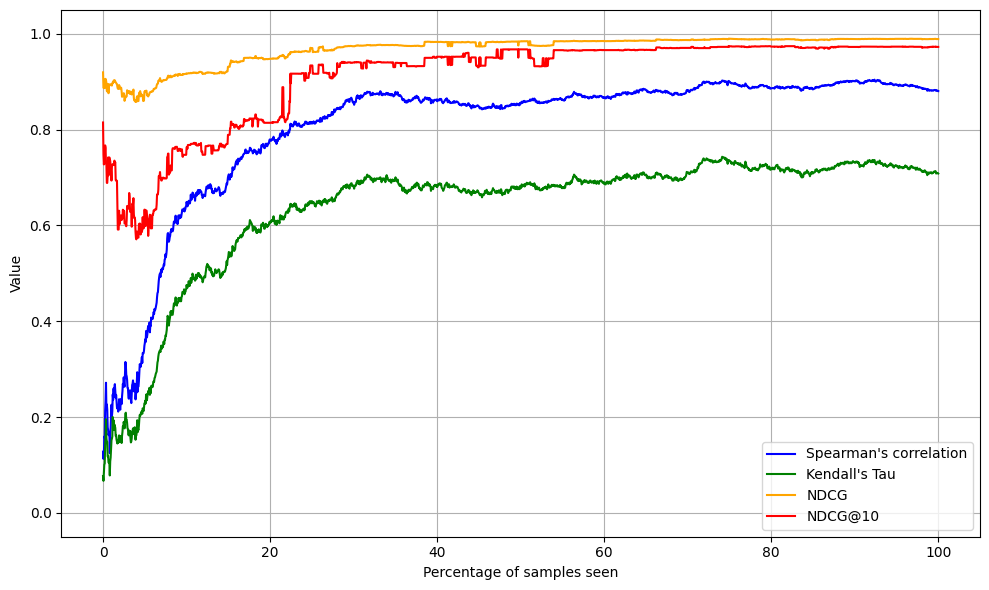

In [107]:
x = np.linspace(0,100, num=len(spearman_values_spm))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_spm, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_spm, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_spm, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_spm, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [109]:
spearman_values_mal = []
kendall_values_mal = []
ndcg_values_mal = []
ndcg10_values_mal = []
initial_samples = random_sampling(malicious_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in malicious_df.iterrows()
    if row['noisy rank'] not in initial_samples
]
malicious_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2)
initial_ranking = malicious_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr,_ = spearmanr(true_ranks, pred_ranks)
tau, _ = kendalltau(true_ranks, pred_ranks)
tau_distance = 1 - tau

y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
spearman_values_mal.append(spearman_corr)
kendall_values_mal.append(tau)
ndcg_values_mal.append(ndcg)
ndcg10_values_mal.append(ndcg10)

In [268]:
with tqdm(total=9900) as pbar:

    while len(remaining_samples)>0:
        new_samples = margin_uncertainty_sampling(remaining_samples, n_samples_per_iter, malicious_params)
        
        initial_samples.extend(new_samples)
        for sample in new_samples:
            remaining_samples.remove(sample)
        malicious_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=malicious_params)
        predicted_ranking_mal = malicious_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_mal)
        spearman_corr, _= spearmanr(true_ranks, pred_ranks)
        tau, _ = kendalltau(true_ranks, pred_ranks)
        y_true = [relevance[item] for item in predicted_ranking_mal]
        y_score = list(reversed(range(1, len(predicted_ranking_mal) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
    
        spearman_values_mal.append(spearman_corr)
        kendall_values_mal.append(tau)
        ndcg_values_mal.append(ndcg)
        ndcg10_values_mal.append(ndcg10)
        pbar.update(5)

100%|██████████| 9900/9900 [08:44<00:00, 18.87it/s]


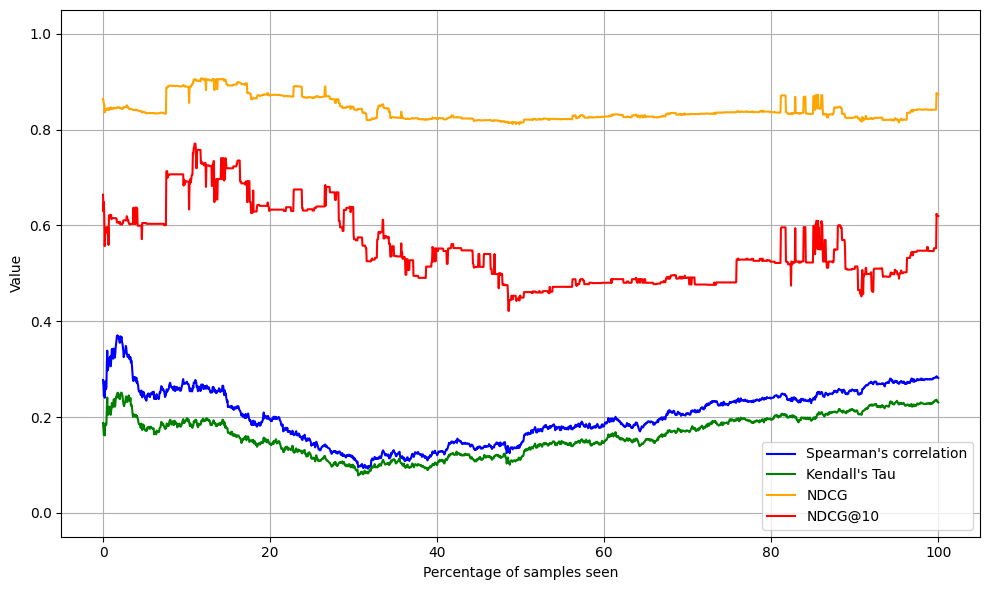

In [269]:
x = np.linspace(0,100, num=len(spearman_values_mal))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_mal, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_mal, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_mal, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_mal, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [110]:
with tqdm(total=10000) as pbar:
    while len(remaining_samples) > 0:
        new_samples = 0
        while new_samples < 5:
            worker = sample_worker(malicious_probs)
            worker_ranks = [rank for wid, rank in remaining_samples if wid == worker]
            if len(worker_ranks) > 0:
                new_sample = margin_uncertainty_sampling(worker_ranks, 1, malicious_params)[0]
                initial_samples.append(new_sample)
                s_tuple = (worker,new_sample)
                remaining_samples.remove(s_tuple)
                new_samples += 1
            else:
                continue
        malicious_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=malicious_params)
        predicted_ranking_mal = malicious_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_mal)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_mal]
        y_score = list(reversed(range(1, len(predicted_ranking_mal) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_mal.append(spearman_corr)
        kendall_values_mal.append(tau)
        ndcg_values_mal.append(ndcg)
        ndcg10_values_mal.append(ndcg10)
        pbar.update(5)

 99%|█████████▊| 9865/10000 [02:48<00:02, 58.57it/s]


KeyboardInterrupt: 

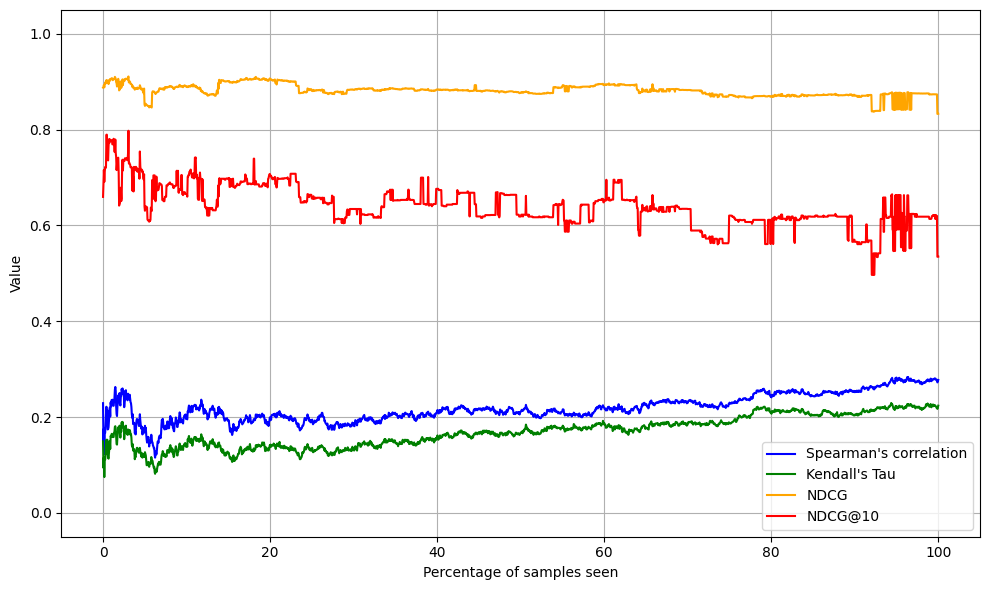

In [111]:
x = np.linspace(0,100, num=len(spearman_values_mal))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_mal, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_mal, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_mal, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_mal, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
def spearman_rank_corr(sample_a, sample_b):
    rank_a = torch.argsort(torch.argsort(sample_a))
    rank_b = torch.argsort(torch.argsort(sample_b))

    d = rank_a - rank_b
    n = len(sample_a)

    spearman_corr = 1 - (6 * torch.sum(d ** 2)) / (n * (n ** 2 - 1))
    return spearman_corr

In [37]:
def diversity_sampling(dataset, n_samples, model_params):

    model_params = torch.tensor(model_params, dtype=torch.float32, device='cuda')
    selected_samples = []
    
    samples = torch.tensor(dataset, dtype=torch.long, device='cuda')
    predicted_ranking = torch.argsort(model_params)
    
    spearman_distances = []

    for sample in samples:
        # Compute Spearman's rank correlation for this sample with already selected samples
        spearman_corrs = []
        
        # Compare with already selected samples
        for selected_sample in selected_samples:
            spearman_corr = spearman_rank_corr_gpu(sample, selected_sample)
            spearman_corrs.append(spearman_corr)
        
        # Compute mean Spearman correlation with already selected samples
        mean_spearman_corr = torch.mean(torch.tensor(spearman_corrs, device="cuda")) if spearman_corrs else torch.tensor(0.0, device="cuda")
        
        # Add the sample and its mean correlation (distance) to the list
        spearman_distances.append((sample, mean_spearman_corr))
    
    # Sort the samples based on their dissimilarity (lowest correlation means more dissimilar)
    spearman_distances.sort(key=lambda x: x[1], reverse=False)
    
    # Select the n_samples most dissimilar samples
    selected_samples = [sample.cpu().tolist() for sample, _ in spearman_distances[:n_samples]]
    return selected_samples

In [119]:
spearman_values_exp_div = []
kendall_values_exp_div = []
ndcg_values_exp_div = []
ndcg10_values_exp_div = []
initial_samples = random_sampling(expert_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in expert_df.iterrows()
    if row['noisy rank'] not in initial_samples
]
expert_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2)
initial_ranking = expert_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr,_ = spearmanr(true_ranks, pred_ranks)
tau, _ = kendalltau(true_ranks, pred_ranks)
tau_distance = 1 - tau

y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
spearman_values_exp_div.append(spearman_corr)
kendall_values_exp_div.append(tau)
ndcg_values_exp_div.append(ndcg)
ndcg10_values_exp_div.append(ndcg10)

In [295]:
with tqdm(total=9900) as pbar:
    while len(remaining_samples) > 0:
        new_samples = diversity_sampling(remaining_samples, n_items, n_samples_per_iter, expert_params)
        initial_samples.extend(new_samples)
        for sample in new_samples:
            remaining_samples.remove(sample)
        expert_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=expert_params)
        
        predicted_ranking_exp = expert_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_exp)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_exp]
        y_score = list(reversed(range(1, len(predicted_ranking_exp) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_exp_div.append(spearman_corr)
        kendall_values_exp_div.append(tau)
        ndcg_values_exp_div.append(ndcg)
        ndcg10_values_exp_div.append(ndcg10)
        pbar.update(5)

NameError: name 't' is not defined

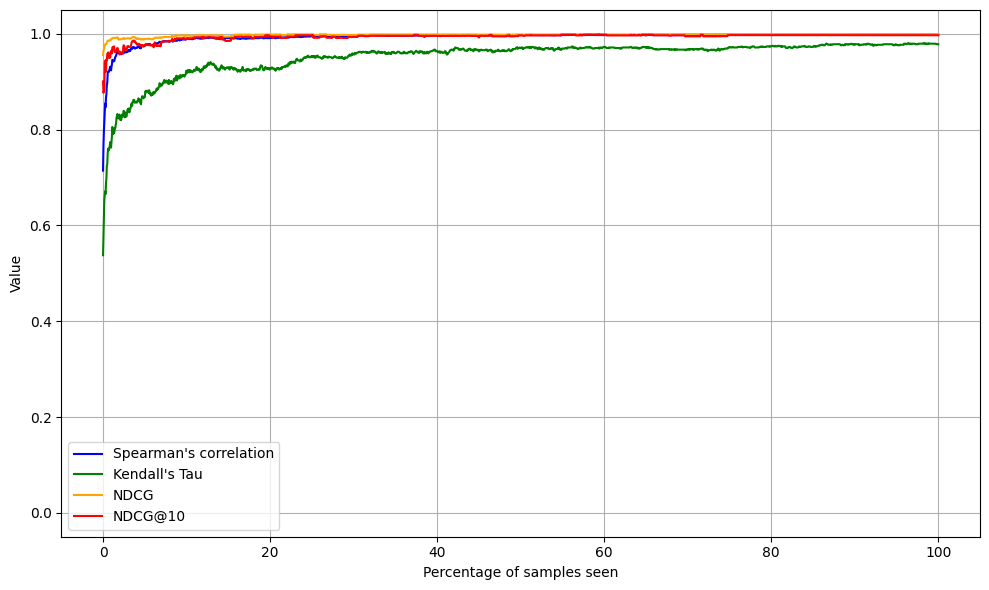

<Figure size 640x480 with 0 Axes>

In [259]:
x = np.linspace(0,100, num=len(spearman_values_exp_div))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_exp_div, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_exp_div, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_exp_div, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_exp_div, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('diversity-expert.png')

In [120]:
with tqdm(total=10000) as pbar:
    while len(remaining_samples) > 0:
        new_samples = 0
        while new_samples < 5:
            worker = sample_worker(expert_probs)
            worker_ranks = [rank for wid, rank in remaining_samples if wid == worker]
            if len(worker_ranks) > 0:
                new_sample = diversity_sampling(worker_ranks, 1, expert_params)[0]
                initial_samples.append(new_sample)
                s_tuple = (worker,new_sample)
                remaining_samples.remove(s_tuple)
                new_samples += 1
            else:
                continue
        expert_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=expert_params)
        predicted_ranking_exp = expert_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_exp)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_exp]
        y_score = list(reversed(range(1, len(predicted_ranking_exp) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_exp_div.append(spearman_corr)
        kendall_values_exp_div.append(tau)
        ndcg_values_exp_div.append(ndcg)
        ndcg10_values_exp_div.append(ndcg10)
        pbar.update(5)

 99%|█████████▉| 9885/10000 [03:01<00:02, 54.41it/s]


KeyboardInterrupt: 

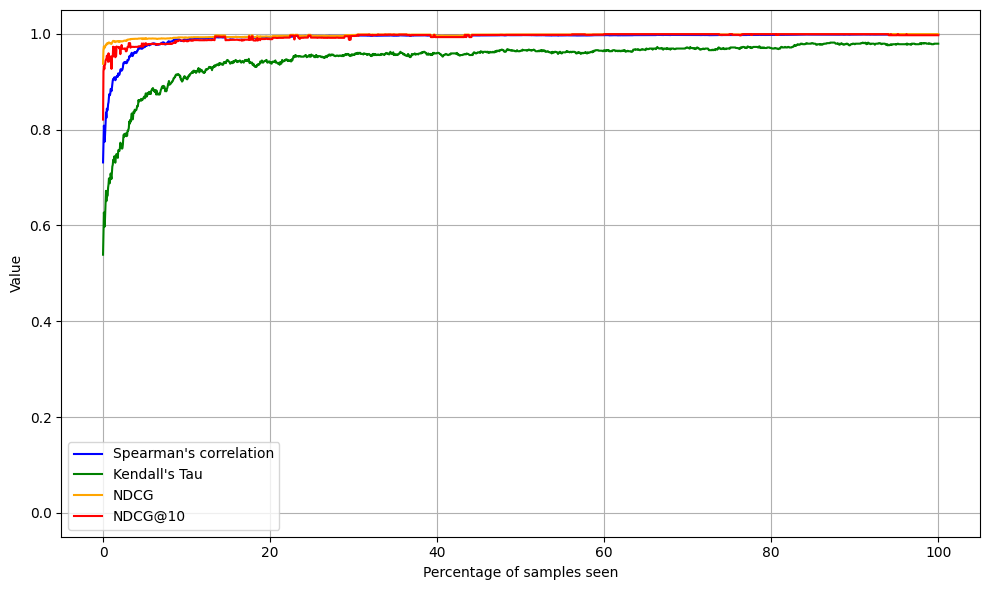

<Figure size 640x480 with 0 Axes>

In [121]:
x = np.linspace(0,100, num=len(spearman_values_exp_div))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_exp_div, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_exp_div, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_exp_div, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_exp_div, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('diversity-expert.png')

In [40]:
spearman_values_am_div = []
kendall_values_am_div = []
ndcg_values_am_div = []
ndcg10_values_am_div = []
initial_samples = random_sampling(amateur_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in amateur_df.iterrows()
    if row['noisy rank'] not in initial_samples
]
amateur_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2)
initial_ranking = amateur_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr,_ = spearmanr(true_ranks, pred_ranks)
tau, _ = kendalltau(true_ranks, pred_ranks)
tau_distance = 1 - tau

y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
spearman_values_am_div.append(spearman_corr)
kendall_values_am_div.append(tau)
ndcg_values_am_div.append(ndcg)
ndcg10_values_am_div.append(ndcg10)

In [298]:
with tqdm(total=9900) as pbar:
    while len(remaining_samples) > 0:
        new_samples = diversity_sampling(remaining_samples, n_items, n_samples_per_iter, amateur_params)
        initial_samples.extend(new_samples)
        for sample in new_samples:
            remaining_samples.remove(sample)
        amateur_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=amateur_params)
        
        predicted_ranking_am = amateur_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_am)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_am]
        y_score = list(reversed(range(1, len(predicted_ranking_am) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_am_div.append(spearman_corr)
        kendall_values_am_div.append(tau)
        ndcg_values_am_div.append(ndcg)
        ndcg10_values_am_div.append(ndcg10)
        pbar.update(5)

100%|██████████| 9900/9900 [08:12<00:00, 20.12it/s] 


In [ ]:
x = np.linspace(0,100, num=len(spearman_values_am_div))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_am_div, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_am_div, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_am_div, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_am_div, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
with tqdm(total=10000) as pbar:
    while len(remaining_samples) > 0:
        new_samples = 0
        while new_samples < 5:
            worker = sample_worker(amateur_probs)
            worker_ranks = [rank for wid, rank in remaining_samples if wid == worker]
            if len(worker_ranks) > 0:
                new_sample = diversity_sampling(worker_ranks, 1, amateur_params)[0]
                initial_samples.append(new_sample)
                s_tuple = (worker,new_sample)
                remaining_samples.remove(s_tuple)
                new_samples += 1
            else:
                continue
        amateur_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=amateur_params)
        predicted_ranking_am = amateur_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_am)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_am]
        y_score = list(reversed(range(1, len(predicted_ranking_am) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_am_div.append(spearman_corr)
        kendall_values_am_div.append(tau)
        ndcg_values_am_div.append(ndcg)
        ndcg10_values_am_div.append(ndcg10)
        pbar.update(5)

 99%|█████████▉| 9890/10000 [02:59<00:01, 55.18it/s]


KeyboardInterrupt: 

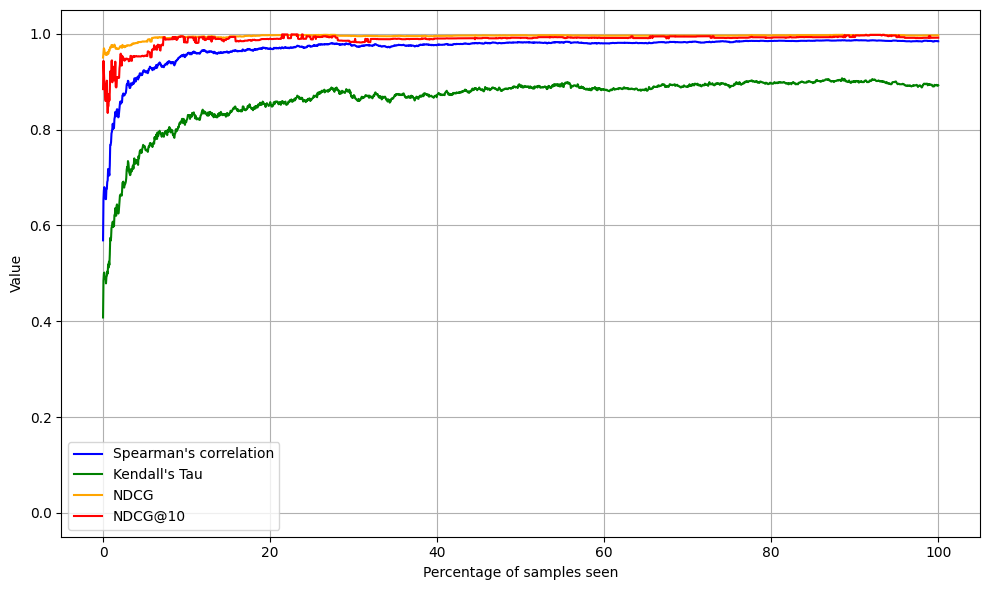

In [42]:
x = np.linspace(0,100, num=len(spearman_values_am_div))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_am_div, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_am_div, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_am_div, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_am_div, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
spearman_values_spm_div = []
kendall_values_spm_div = []
ndcg_values_spm_div = []
ndcg10_values_spm_div = []
initial_samples = random_sampling(spammer_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in spammer_df.iterrows()
    if row['noisy rank'] not in initial_samples
]
spammer_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2)
initial_ranking = spammer_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr,_ = spearmanr(true_ranks, pred_ranks)
tau, _ = kendalltau(true_ranks, pred_ranks)
tau_distance = 1 - tau

y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
spearman_values_spm_div.append(spearman_corr)
kendall_values_spm_div.append(tau)
ndcg_values_spm_div.append(ndcg)
ndcg10_values_spm_div.append(ndcg10)

In [305]:
with tqdm(total=9900) as pbar:
    while len(remaining_samples) > 0:
        new_samples = diversity_sampling(remaining_samples, n_items, n_samples_per_iter, spammer_params)
        initial_samples.extend(new_samples)
        for sample in new_samples:
            remaining_samples.remove(sample)
        spammer_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=spammer_params)
        
        predicted_ranking_spm = spammer_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_spm)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_spm]
        y_score = list(reversed(range(1, len(predicted_ranking_spm) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_spm_div.append(spearman_corr)
        kendall_values_spm_div.append(tau)
        ndcg_values_spm_div.append(ndcg)
        ndcg10_values_spm_div.append(ndcg10)
        pbar.update(5)

100%|██████████| 9900/9900 [08:22<00:00, 19.72it/s] 


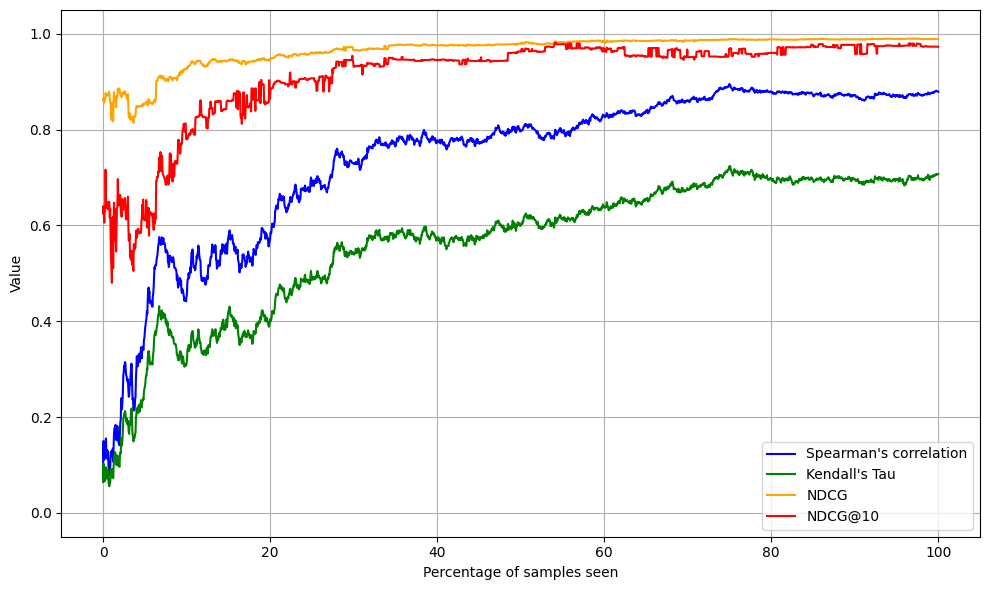

In [306]:
x = np.linspace(0,100, num=len(spearman_values_spm_div))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_spm_div, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_spm_div, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_spm_div, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_spm_div, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
with tqdm(total=10000) as pbar:
    while len(remaining_samples) > 0:
        new_samples = 0
        while new_samples < 5:
            worker = sample_worker(spammer_probs)
            worker_ranks = [rank for wid, rank in remaining_samples if wid == worker]
            if len(worker_ranks) > 0:
                new_sample = diversity_sampling(worker_ranks, 1, spammer_params)[0]
                initial_samples.append(new_sample)
                s_tuple = (worker,new_sample)
                remaining_samples.remove(s_tuple)
                new_samples += 1
            else:
                continue
        spammer_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=spammer_params)
        predicted_ranking_spm = spammer_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_spm)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_spm]
        y_score = list(reversed(range(1, len(predicted_ranking_spm) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_spm_div.append(spearman_corr)
        kendall_values_spm_div.append(tau)
        ndcg_values_spm_div.append(ndcg)
        ndcg10_values_spm_div.append(ndcg10)
        pbar.update(5)

 99%|█████████▉| 9895/10000 [03:21<00:02, 49.06it/s]


KeyboardInterrupt: 

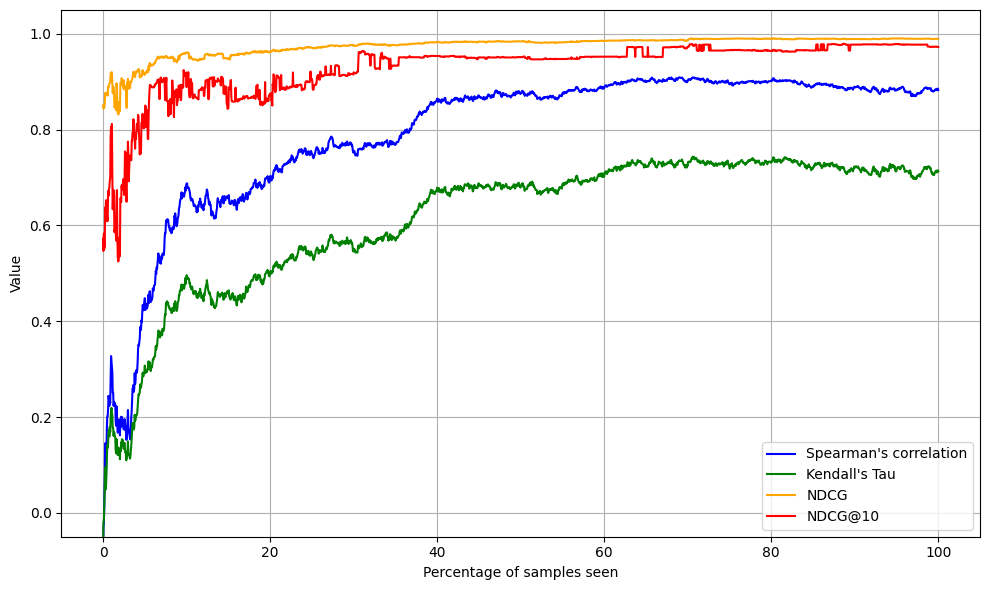

In [45]:
x = np.linspace(0,100, num=len(spearman_values_spm_div))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_spm_div, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_spm_div, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_spm_div, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_spm_div, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
spearman_values_mal_div = []
kendall_values_mal_div = []
ndcg_values_mal_div = []
ndcg10_values_mal_div = []
initial_samples = random_sampling(malicious_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in malicious_df.iterrows()
    if row['noisy rank'] not in initial_samples
]
malicious_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2)
initial_ranking = malicious_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr,_ = spearmanr(true_ranks, pred_ranks)
tau, _ = kendalltau(true_ranks, pred_ranks)
tau_distance = 1 - tau

y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
spearman_values_mal_div.append(spearman_corr)
kendall_values_mal_div.append(tau)
ndcg_values_mal_div.append(ndcg)
ndcg10_values_mal_div.append(ndcg10)

In [308]:
with tqdm(total=9900) as pbar:
    while len(remaining_samples) > 0:
        new_samples = diversity_sampling(remaining_samples, n_items, n_samples_per_iter, malicious_params)
        initial_samples.extend(new_samples)
        for sample in new_samples:
            remaining_samples.remove(sample)
        malicious_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=malicious_params)
        
        predicted_ranking_mal = malicious_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_mal)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_mal]
        y_score = list(reversed(range(1, len(predicted_ranking_mal) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_mal_div.append(spearman_corr)
        kendall_values_mal_div.append(tau)
        ndcg_values_mal_div.append(ndcg)
        ndcg10_values_mal_div.append(ndcg10)
        pbar.update(5)

100%|██████████| 9900/9900 [08:16<00:00, 19.92it/s] 


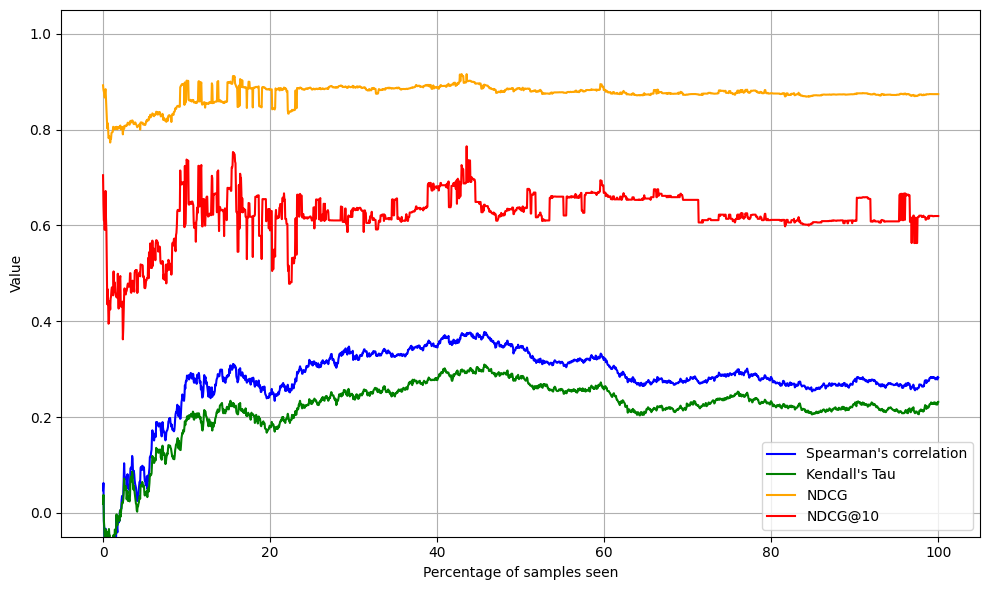

In [309]:
x = np.linspace(0,100, num=len(spearman_values_mal_div))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_mal_div, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_mal_div, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_mal_div, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_mal_div, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
with tqdm(total=10000) as pbar:
    while len(remaining_samples) > 0:
        new_samples = 0
        while new_samples < 5:
            worker = sample_worker(malicious_probs)
            worker_ranks = [rank for wid, rank in remaining_samples if wid == worker]
            if len(worker_ranks) > 0:
                new_sample = diversity_sampling(worker_ranks, 1, malicious_params)[0]
                initial_samples.append(new_sample)
                s_tuple = (worker,new_sample)
                remaining_samples.remove(s_tuple)
                new_samples += 1
            else:
                continue
        malicious_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=malicious_params)
        predicted_ranking_mal = malicious_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_mal)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_mal]
        y_score = list(reversed(range(1, len(predicted_ranking_mal) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_mal_div.append(spearman_corr)
        kendall_values_mal_div.append(tau)
        ndcg_values_mal_div.append(ndcg)
        ndcg10_values_mal_div.append(ndcg10)
        pbar.update(5)

 99%|█████████▊| 9865/10000 [02:49<00:02, 58.09it/s]


KeyboardInterrupt: 

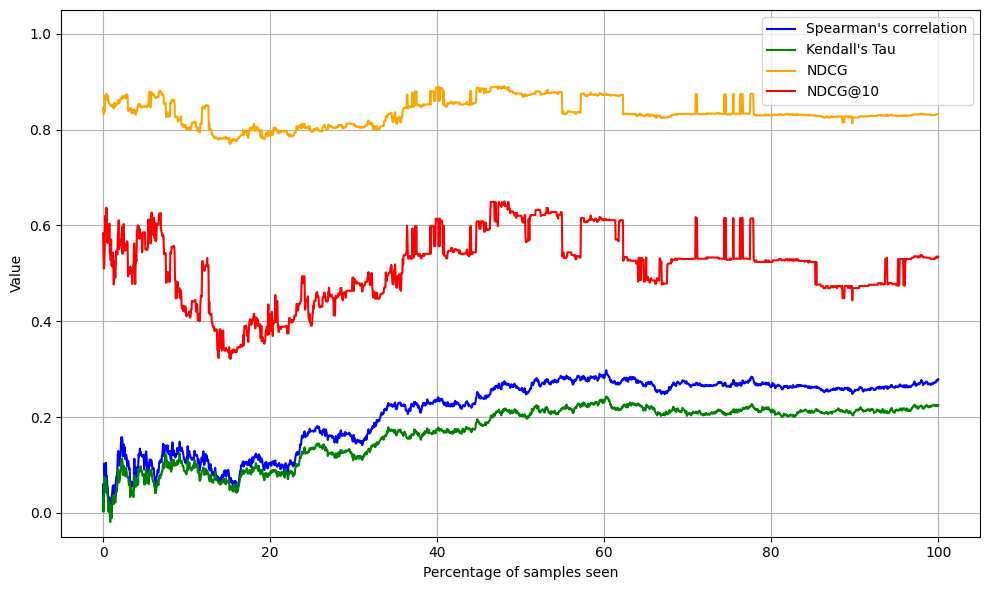

In [48]:
x = np.linspace(0,100, num=len(spearman_values_mal_div))
plt.figure(figsize=(10, 6))
plt.plot(x, spearman_values_mal_div, label="Spearman's correlation", color="blue")
plt.plot(x, kendall_values_mal_div, label="Kendall's Tau", color="green")
plt.plot(x, ndcg_values_mal_div, label="NDCG", color="orange")
plt.plot(x, ndcg10_values_mal_div, label = "NDCG@10", color="red")
plt.xlabel("Percentage of samples seen")
plt.ylabel("Value")
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
def l1_distance(p1,p2):
    return np.sum(np.abs(p1-p2))

In [344]:
expert_df.head()

,worker id,subset,true rank,noisy rank
0,0,"[30, 37, 49]","[49, 30, 37]","[49, 30, 37]"
1,0,"[0, 2, 4]","[4, 2, 0]","[4, 2, 0]"
2,0,"[30, 37, 53]","[53, 30, 37]","[53, 30, 37]"
3,0,"[32, 37, 42]","[32, 42, 37]","[32, 42, 37]"
4,0,"[16, 40, 48]","[16, 48, 40]","[16, 48, 40]"


In [345]:
l1_distance(choix.probabilities([49, 30, 37],expert_params),choix.probabilities([4, 2, 0],expert_params))

0.47737016756666006

In [346]:
choix.probabilities([49, 30, 37],expert_params)

array([0.60063601, 0.27364744, 0.12571655])

In [347]:
choix.probabilities([4, 2, 0],expert_params)

array([0.36195093, 0.29227384, 0.34577523])

In [50]:
def diversity_sampling_probs(dataset, n_samples, samples, model_params):
    selected = list(samples)
    remaining = list(dataset)
    sample_probs = {tuple(sample): choix.probabilities(sample, model_params) for sample in remaining}
    #print(sample_probs)
    new_selected = []
    for _ in range(n_samples):
        best_sample = None
        max_min_dist = -np.inf
        for s in remaining:
            p_sample = sample_probs[tuple(s)]
            min_dist = min(l1_distance(p_sample, choix.probabilities(s, model_params)) 
                    for s in selected)
            if min_dist > max_min_dist:
                max_min_dist = min_dist
                best_sample = s

        if best_sample is not None:
            new_selected.append(best_sample)
            selected.append(best_sample)
            remaining.remove(best_sample)
        print(best_sample)
    return new_selected

    

In [51]:
spearman_values_exp_div = []
kendall_values_exp_div = []
ndcg_values_exp_div = []
ndcg10_values_exp_div = []
initial_samples = random_sampling(expert_df['noisy rank'], n_initial_samples)
remaining_samples = [
    (row['worker id'], row['noisy rank'])
    for _, row in expert_df.iterrows()
    if row['noisy rank'] not in initial_samples
]
expert_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2)
initial_ranking = expert_params.argsort()
true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, initial_ranking)
spearman_corr,_ = spearmanr(true_ranks, pred_ranks)
tau, _ = kendalltau(true_ranks, pred_ranks)
tau_distance = 1 - tau

y_true = [relevance[item] for item in initial_ranking]
y_score = list(reversed(range(1, len(initial_ranking) + 1)))

y_true = np.asarray([y_true])
y_score = np.asarray([y_score])
ndcg = ndcg_score(y_true, y_score)
ndcg10 = ndcg_score(y_true, y_score, k=10)
spearman_values_exp_div.append(spearman_corr)
kendall_values_exp_div.append(tau)
ndcg_values_exp_div.append(ndcg)
ndcg10_values_exp_div.append(ndcg10)

In [52]:
with tqdm(total=9900) as pbar:
    while len(remaining_samples) > 0:
        new_samples = diversity_sampling_probs(remaining_samples, n_samples_per_iter, initial_samples, expert_params)
        initial_samples.extend(new_samples)
        for sample in new_samples:
            remaining_samples.remove(sample)
        expert_params = choix.lsr_rankings(n_items=n_items, data=initial_samples, alpha=1e-2, initial_params=expert_params)
        
        predicted_ranking_exp = expert_params.argsort()
        true_ranks, pred_ranks = aligned_rank_vectors(true_ranking, predicted_ranking_exp)
        spearman_corr, p_value_s = spearmanr(true_ranks, pred_ranks)
        tau, p_value_k = kendalltau(true_ranks, pred_ranks)
        tau_distance = 1 - tau
    
        y_true = [relevance[item] for item in predicted_ranking_exp]
        y_score = list(reversed(range(1, len(predicted_ranking_exp) + 1)))
        
        y_true = np.asarray([y_true])
        y_score = np.asarray([y_score])
        ndcg = ndcg_score(y_true, y_score)
        ndcg10 = ndcg_score(y_true, y_score, k=10)
        spearman_values_exp_div.append(spearman_corr)
        kendall_values_exp_div.append(tau)
        ndcg_values_exp_div.append(ndcg)
        ndcg10_values_exp_div.append(ndcg10)
        pbar.update(5)

  0%|          | 0/9900 [00:00<?, ?it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.